# Optimizing diversified investment portfolios considering cryptocurrencies and other Brazilian financial products, using Markowitz model approach, GARCH models and Genetic algorithms.

*** By Pablo Calvache***

In [200]:
#Imports

from bs4 import BeautifulSoup
from io import StringIO
import pandas as pd
import certifi
import urllib3
import pycurl
import datetime, time

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import warnings

from datetime import datetime
from dateutil.relativedelta import relativedelta

%matplotlib inline

# Data extraction

Using Python curl and HTML libraries, data from websites containing closing prices of either stocks and cryptocurrencies assets, is extracted and summarized. Such data is public!

** OBS: ** Regardless the Brazilian stocks prices are given in *BRL (Real)* and the crypto prices are given in *USD (American Dolar)*,  transforming from USD to BRL is desnecessary due only differentiated series are considered by Markowitz models. 

## Stock info

Data at this stage, is obtained from Yahoo finance portal because of its HTML structure and easiness at reading.  

In [8]:
# https://br.financas.yahoo.com/quote/PETR4.SA/history?period1=1452045600&period2=1515549600&interval=1d&filter=history&frequency=1d
def date_to_seconds(date_string, formatting = '%d-%m-%Y' ):
    t = datetime.datetime.strptime(date_string, formatting)
    return int(time.mktime(t.timetuple()))

def get_historical_data(name, init, end):
    data_close_prices, index_date = [], []
    url = "https://br.finance.yahoo.com/quote/"+name+"/history?period1="+str(init)+"&period2="+str(end)+"&interval=1d&filter=history&frequency=1d"
    print('Downloading from ... '+ url)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    r = http.request('GET', url)
    rows = BeautifulSoup(r.data, 'html.parser').findAll('table')[1].tbody.findAll('tr')
    
    for each_row in rows:
        divs = each_row.findAll('td')
        #data.append({'date': divs[0].text, 
                    #'open': divs[1].text,
                    #'max': divs[2].text,
                    #'min': divs[3].text,
                    #'close': divs[4].text})
                    
        if len(divs) < 4:
            continue
            
        data_close_prices.append(float(divs[4].text.replace(",", ".")))
        index_date.append(divs[0].text)
    
    key = 'stock_close_'+name.split('.')[0]
    return pd.DataFrame({key:list(reversed(data_close_prices))}, index = list(reversed(index_date)))

def download_portafolio_as_pandas(papers, interval):
    portafolio_pd = pd.DataFrame()
    for paper in papers:
        init_sec = date_to_seconds(interval['init'])
        end_sec = date_to_seconds(interval['end'])
        if portafolio_pd.size == 0:
            portafolio_pd = get_historical_data(paper, init_sec, end_sec)
        else:
            portafolio_pd = portafolio_pd.join(get_historical_data(paper, init_sec, end_sec), how ='left')
    
    return portafolio_pd

In [9]:
# downloading data

papers = ["ABEV3.SA", "ITUB4.SA", "BBDC3.SA", "PETR4.SA", "VALE3.SA", "BSAN33.SA", "ITSA4.SA", 
          "VIVT4.SA", "BBSE3.SA", "CIEL3.SA"]

#"BRSR6.SA","ELET6.SA","CESP6.SA","PCAR4.SA",
#          "CGAS5.SA","CMIG4.SA","CPLE6.SA","ELPL4.SA",

# Yahoo allows to download 100 days only, therefore
time_intervals = [{'init' : '01-06-2018', 'end' : '20-06-2018'},
                  {'init' : '06-03-2018', 'end' : '30-05-2018'},
                  {'init' : '01-09-2017', 'end' : '05-03-2018'},
                  {'init' : '13-04-2017', 'end' : '31-08-2017'},
                  {'init' : '01-01-2017', 'end' : '12-04-2017'}]

stock_prices_pd = pd.DataFrame()
for time_interval in time_intervals:
    if stock_prices_pd.size == 0:
        stock_prices_pd = download_portafolio_as_pandas(papers, time_interval)
    else:
        stock_prices_pd = pd.concat([download_portafolio_as_pandas(papers, time_interval), stock_prices_pd])

#### Formatting Date index

In [10]:
def formating_yahoo_date(date_text):
    date_text = date_text.replace(' de ', '-')
    splitted_date = date_text.split('-')
    day, month_pt, year = splitted_date[0], splitted_date[1], splitted_date[2]
    return {
      'dez': lambda year, day: year + '-' + '12' + '-' + day,
      'nov': lambda year, day: year + '-' + '11' + '-' + day,
      'out': lambda year, day: year + '-' + '10' + '-' + day,
      'set': lambda year, day: year + '-' + '09' + '-' + day,
      'ago': lambda year, day: year + '-' + '08' + '-' + day,
      'jul': lambda year, day: year + '-' + '07' + '-' + day,
      'jun': lambda year, day: year + '-' + '06' + '-' + day,
      'mai': lambda year, day: year + '-' + '05' + '-' + day,
      'abr': lambda year, day: year + '-' + '04' + '-' + day,
      'mar': lambda year, day: year + '-' + '03' + '-' + day,
      'fev': lambda year, day: year + '-' + '02' + '-' + day,
      'jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

stock_prices_pd.index = [formating_yahoo_date(date_yahoo) for date_yahoo in stock_prices_pd.index.values]

In [13]:
stock_prices_pd.head()

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
2017-01-02,16.31,33.53,23.82,14.66,25.06,16.0,7.41,44.08,27.82,22.71
2017-01-03,16.64,34.95,24.77,15.50,26.17,16.0,7.74,44.53,28.81,23.34
2017-01-04,16.51,35.10,24.76,15.50,25.70,16.0,7.78,44.35,29.72,23.01
2017-01-05,16.60,35.58,24.90,15.75,26.68,16.0,7.86,43.60,29.12,22.76
2017-01-06,16.46,35.70,25.09,15.66,25.97,16.0,7.83,43.71,28.67,22.81


## Croptocurrencies

#### Loading Objects from coinMarket

Due criptocurrencies are harder to trade and exchange, an important criterion in ordet to select the correct ones is the ease in exhancging... 

In [11]:
#date format = 20170817
def formating_coinmarket_date(date_text):
    date_text = date_text.replace(',', '')
    splitted_date = date_text.split(' ')
    day, month_pt, year = splitted_date[1], splitted_date[0], splitted_date[2]
    return {
      'Dec': lambda year, day: year + '-' + '12' + '-' + day,
      'Nov': lambda year, day: year + '-' + '11' + '-' + day,
      'Oct': lambda year, day: year + '-' + '10' + '-' + day,
      'Sep': lambda year, day: year + '-' + '09' + '-' + day,
      'Aug': lambda year, day: year + '-' + '08' + '-' + day,
      'Jul': lambda year, day: year + '-' + '07' + '-' + day,
      'Jun': lambda year, day: year + '-' + '06' + '-' + day,
      'May': lambda year, day: year + '-' + '05' + '-' + day,
      'Apr': lambda year, day: year + '-' + '04' + '-' + day,
      'Mar': lambda year, day: year + '-' + '03' + '-' + day,
      'Feb': lambda year, day: year + '-' + '02' + '-' + day,
      'Jan': lambda year, day: year + '-' + '01' + '-' + day
    }[month_pt](year, day)

def get_values_table(source_path, currency, start_date, end_date):
    url = source_path.format(currency = currency, start_date = start_date, end_date = end_date)
    http = urllib3.PoolManager(cert_reqs='CERT_REQUIRED', ca_certs=certifi.where())
    print('Downloading from ... '+ url)
    r = http.request('GET', url)
    #r = urllib.urlopen(url).read() # Python 2
    soup = BeautifulSoup(r.data, 'html.parser')
    table = soup.find('table')
    data = []
    table_body = table.find('tbody')

    rows = table_body.find_all('tr')
    for row in rows:
        cols = row.find_all('td')
        cols = [ele.text.strip() for ele in cols]
        data.append([ele for ele in cols if ele]) # Get rid of empty values
    
    df_temp = pd.DataFrame.from_records(list(reversed(data)))
    df_temp.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Market Cap']
   
    close_prices = [float(close) for close in list(df_temp['Close'])]
    df_close = pd.DataFrame({'ccurr_'+currency+'_close' : close_prices}, index = df_temp['Date'])
    
    return df_close

def download_cripto_currencies_close_price_as_pandas(currencies, date_interval):
    source_path = 'https://coinmarketcap.com/currencies/{currency}/historical-data/?start={start_date}&end={end_date}'
    ccurrencies_pd = pd.DataFrame()
    for key, val in currencies.items():
        if ccurrencies_pd.size == 0:
            ccurrencies_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
        else:
            temp_pd = get_values_table(source_path, currencies[key], 
                       date_interval['init'].replace('-',''), 
                       date_interval['end'].replace('-',''))
            ccurrencies_pd = ccurrencies_pd.join(temp_pd, how ='left')
    
    return ccurrencies_pd

def from_usd_to_pt(currencies_pd, exchange_pd):
    currencies_pd_temp = currencies_pd.join(exchange_pd, how='inner')
    return cripto_currencies_pd.transform(lambda x: x * currencies_pd_temp['close_price_usd_pt'])

In [12]:
currencies = {'bitcoin' : 'bitcoin', 
              'ethereum' : 'ethereum', 
              'bitcoin_cash' : 'bitcoin-cash', 
              'litecoin' : 'litecoin',
              'ripple' : 'ripple',
              'Cardano' : 'cardano',
              'NEO' : 'neo',
              'stellar': 'stellar',
              'monero' : 'monero',
              'EOS' : 'eos',
              'IOTA' : 'iota',
              'EOS' : 'eos',
              'tether' : 'tether',
              'TRON' : 'tron',
              'dash' : 'dash'}

date_interval = {'init': '2017-01-01', 'end' : '2018-06-20' }

cripto_currencies_pd = download_cripto_currencies_close_price_as_pandas(currencies, date_interval)
cripto_currencies_pd.index =[formating_coinmarket_date(date_coinm) for date_coinm in cripto_currencies_pd.index.values]
#cripto_currencies_pd = from_usd_to_pt(cripto_currencies_pd, usd_br_pd)

In [8]:
# trabajar con coingecko - op 1
# 
cripto_currencies_pd.head()

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,998.33,8.17,NaN,4.51,0.006368,NaN,0.141841,0.002481,13.97,NaN,NaN,1.0,NaN,11.23
2017-01-02,1021.75,8.38,NaN,4.65,0.006311,NaN,0.145642,0.002477,16.05,NaN,NaN,1.0,NaN,11.81
2017-01-03,1043.84,9.73,NaN,4.63,0.006386,NaN,0.140422,0.002554,16.09,NaN,NaN,1.0,NaN,12.78
2017-01-04,1154.73,11.25,NaN,4.84,0.006570,NaN,0.136734,0.002735,18.53,NaN,NaN,1.0,NaN,16.52
2017-01-05,1013.38,10.25,NaN,4.29,0.006201,NaN,0.131070,0.002598,16.19,NaN,NaN,1.0,NaN,14.38


## Preprocessing, financial time series theory

In order to avoid biases caused by sporious correlations and not stationary trends a and variance, the original 'closing price' series of each asset, a derivation and logaritmic scale transformation is performed in order to make the series stationary in trend and variance. Such method delivers the data in a format compatible with the Markowitz model input, and such transformations also are kind of standar in finance analyisis.

According to P. Morettin, the relative variance or the *simple liquidity return* $R_t$ of an asset is given by:

$$Rt = \frac{P_t - P_{t-1}}{P_{t-1}}$$


As $R_t$ is defined as the expected return of an asset, generally expressed as a percent value, $r_t$ however is defined as the *return rate* of an asset, given by:

$$r_t = ln(\frac{P_t}{P_{t-1}})$$

Therefore, a simple return $R_t$ is obtained by: 

$$ R_t = {e^{r_t}} - 1 $$


The first term presented above $R_t$, is pretended to be used when the optimization takes place, while $r_t$ is the termo to be predicted with a GARCH model.

In [67]:
# Rt - returns
def get_returns_in_percent(pd_dataframee):
    return (pd_dataframee.diff() / pd_dataframee.shift(periods=1))

# rt - rate returns
def get_rate_return(pd_dataframe):
    pd_temp = np.log(pd_dataframe)
    return pd_temp.diff()

** Non stationary Time Series **

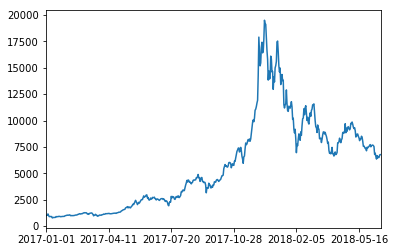

In [68]:
cripto_currencies_pd['ccurr_bitcoin_close'].plot()

** *Diff* or First order Derived Series: Making the series stationary in trend**

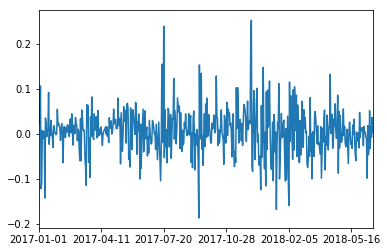

In [69]:
get_returns_in_percent(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

**Most of the time series models works with $r_t$ (spin term??) rather than $R_t$. So by applying the $r_t$ function defined above, we obtain:**

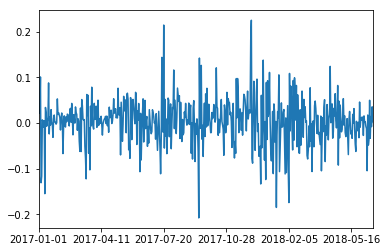

In [70]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].plot()

In [71]:
get_returns_in_percent(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023459,0.025704,NaN,0.031042,-0.008951,NaN,0.026798,-0.001612,0.14889,NaN,NaN,0.0,NaN,0.051647


In [72]:
get_rate_return(cripto_currencies_pd).head(2)

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
2017-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,0.023188,0.025379,NaN,0.03057,-0.008991,NaN,0.026445,-0.001614,0.138797,NaN,NaN,0.0,NaN,0.050358


**OBS:** Despite the similarity in the plots above, returns and return rates are sighlty different from each other. 

** Checking the time series distribution, we get a normal distribution **

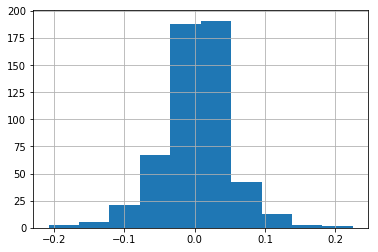

In [73]:
get_rate_return(cripto_currencies_pd)['ccurr_bitcoin_close'].hist()

### Merging Data and filling NaN values

NaN values are in the dataframe due several assets (some cryptocurrencies mainly) have not got a long track closing price history. Such as the case with Cardano and Bit Coin Cash, the first one mentioned for instance has history starting from 13-10-2017 only, hence it is assumed there was not any variance in closing prices difference percent (already differentiated series) before that point filling such missing values with 0. This applies also for None values along the data.

In [112]:
# Stocks percent returns
percent_stocks_returns = get_returns_in_percent(stock_prices_pd)
percent_stocks_returns = percent_stocks_returns.fillna(0)
stock_return_rates = get_rate_return(stock_prices_pd)
stock_return_rates = stock_return_rates.fillna(0)

# Criptocurrencies percent returns
percent_cripto_returns = get_rate_return(cripto_currencies_pd)
percent_cripto_returns = percent_cripto_returns.fillna(0)
ccurr_return_rates = get_rate_return(cripto_currencies_pd)
ccurr_return_rates = ccur_return_rates.fillna(0)

# Merged DF
portafolio_pd = stock_prices_pd.join(cripto_currencies_pd, how = 'inner')
percent_returns_pd = get_rate_return(portafolio_pd)
percent_returns_pd = percent_returns_pd.fillna(0)
return_rates_pd = get_rate_return(portafolio_pd)
return_rates_pd = return_rates_pd.fillna(0)

# Descriptive analysis


**Negative correlation between sotck and cryptocurrencies markets**: Some experts stand of the hyphothesis there is a weak negative correlation between criptocurrencies returns and stock market assets returns regarding FEAR index cotation, it means when there exists hihgher expeculation and fear in markets such as criptocurrencies, the subjective risk is transferred to stocked market.

It is showed in the heat map below with negative (although unexisting sometimes) correlation between the majority of cryptocurrencies and stocks.

In order to appreciate such phenomena, a heatmap showing correlations between all the assets considered is calculated.

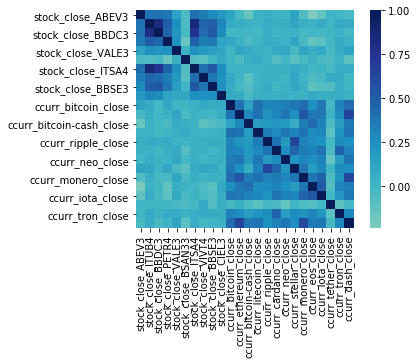

In [87]:
## Pearson correlation - All portafolio
sns.heatmap(percent_returns_pd.tail(360).corr(method='pearson'),  cmap="YlGnBu", center=0, square=True)

The behaviour described in the hypthotesis above, is showed in the data as well, menaning it works also for Brazilian stock assets.

## GARCH models - Getting return value of an asset by using 

**OBS: ** Whenever a GARCH Model does not converge, it is used the mean of the series instead considering recomendations done by some literature regarding the subject, such as (dell course).
"when the data is to messy or may not be able to fit a medium/high complexity model, working with the expected value or mean turns out a better option".

In [456]:
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs


def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return

from arch import arch_model

def fit_garch(TS, p_range = 2, o_range = 0, q_range = 2, dist = "StudentsT"):
    dict_temp = {}
    best_aic = None
    best_order = None
    best_model = None
    for p in range(p_range+1):
        for o in range(o_range+1):
            for q in range(q_range+1):
                try:
                    am = arch_model(TS, p=p, o=o, q=q, dist = 'StudentsT')
                    res = am.fit(update_freq=5, disp='off')
                    tmp_aic = res.aic

                    if best_aic is None:
                        best_aic = tmp_aic
                    if tmp_aic <= best_aic:
                        dict_temp = {'best_aic' : tmp_aic, 'results' : res.forecast().mean.iloc[-1]}
                except:
                    if 'best_aic' not in dict_temp:
                        dict_temp = {'best_aic' : 9999999, 'results' : TS.mean() }
                    continue
    return dict_temp


In [461]:
# Testing
test_returned = ccur_return_rates[145: 175].apply(lambda col: fit_garch(col)['results'])
test_returned

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message i

,ccurr_bitcoin_close,ccurr_ethereum_close,ccurr_bitcoin-cash_close,ccurr_litecoin_close,ccurr_ripple_close,ccurr_cardano_close,ccurr_neo_close,ccurr_stellar_close,ccurr_monero_close,ccurr_eos_close,ccurr_iota_close,ccurr_tether_close,ccurr_tron_close,ccurr_dash_close
h.1,0.004045,0.003822,0.0,0.006162,-0.010336,0.0,0.020073,0.001322,0.003072,0.0,-0.000013,-0.000688,0.0,0.014683


Considering expression: 

$$ R_t = {e^{r_t}} - 1 $$

In [90]:
# Slighlty different from the previous one, but different anyway
test_returned.apply(lambda col: (np.exp(col) - 1))

,stock_close_ABEV3,stock_close_ITUB4,stock_close_BBDC3,stock_close_PETR4,stock_close_VALE3,stock_close_BSAN33,stock_close_ITSA4,stock_close_VIVT4,stock_close_BBSE3,stock_close_CIEL3
h.1,0.000477,0.000648,0.000577,0.001761,0.002488,0.000153,0.00125,0.000231,-0.000118,-0.000641


## Drawing Markowitz efficient frontier


Different from other proposals, this method will take advantage of the already simulated portafolios, trying to reach for the maximum return at each fixed risk value.

For this, it is supposed that the portfolio with the maximum return and te portafolio with the minimal risk belong to the Markowitz efficient frontier, furthermore these ones may allow us to determine the interval of risk values within the quoted frontier. 

### OBS:

When simulating with genetic algorithims, there is a possibility of some portafolios may not match pre-fixed risk value. Furthemore there is a chance than a portafolio with a very close risk of any of the pre-fixed ones, may have a higher return value.

In order to minimize the effect of such issues, the efficient Markowithz frontier is going to be composed by the portafolios with the maximum return within an interval of +- 0.1 per each risk pre-fixed risk point. 

In [91]:
def return_risk_interval(df, number_of_steps = 5): 
    max_return = df.loc[df['return'] == max(df['return'])]
    min_risk = df.loc[df['risk'] == min(df['risk'])]

    delta = (max_return.iloc[0]['risk'] - min_risk.iloc[0]['risk']) / float(number_of_steps)
    if delta == 0:
        delta = 0.00001
    steps = list()

    for i in list(range(0,number_of_steps + 1)):
        if i == 0:
            steps.append(min_risk.iloc[0]['risk'])
        else:
            steps.append(steps[i-1] + delta)

    return [tuple([i-(delta*0.45), i+(delta*0.45)]) for i in steps] # 0,45 * delta guaranties interval overlapping does not Occur  

def drawing_frontier(df):
    steps_risk_interval = return_risk_interval(df)
    frontier = pd.DataFrame()
    for interval in steps_risk_interval:
        sliced_df = df.loc[(df['risk'] > interval[0])&(df['risk'] < interval[1])]

        if len(sliced_df) == 0: # If this condition is True, means for such interval, does not exist a solution.
            continue
            
        max_return_in_interval = max(sliced_df['return'])
        optimal_interval_portafolio = df.loc[df['return'] == max_return_in_interval].iloc[[0]]
        frontier = pd.concat([frontier, optimal_interval_portafolio])
    
    return frontier

# Call to execute
#frontier = drawing_frontier(df_ga_stock_output)  
#sns.lmplot(x="risk", y="distribution_return", data=frontier, fit_reg=True)


### From the portfolios within Markowitz efficient frontier, Ratio Sharpe is the measure that will allow to pick the best one.

According to (EAFIT reference), the most known investement startegies are:

** The equal wiehgt strategy:** Is one of the most used strategy in portfolio diversification due its simplicity in implementation and understading. It simply weights every stock in a portfolio equally.

** Minimum variance strategy:** Based on Markoweitz portfolio optimizatoin model, from the optimizied portfolios set, the portafolio with the minimum value of variance is selected.

** Mean variance straegy:** Once the Markowitz efficient frontier is calculated, Ratio of Sharpe will lead to significant clues about what portfolio may be the best one when the investor does not have a clear idea about the level of risk he would tolerate.

As sawn since the beginning of this work, the model presented in this work includes the last two.

Once the Markowitz frotnier is drawn, an investor is capable to pick the risk he will tolerate considering the probable return the portfolio might offer. But in many cases, if not the most, evaluate in which level of risk is desired to operate could result difficult to do.

Therefore, the ratio of sharpe is introduced as an helpful criterion to overcome such difficulties.  

This metric considers a free-risk asset in order to involve cost of opportunity (similar to ROI value).



$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma} $$

$$ Where \ \sigma = \sqrt{Variance(𝑟_𝑝 − 𝑟_𝑓)} ; if \ 𝑟_𝑓 \ is \ risk-free, \ then: 𝜎 = 𝜎_𝑝 $$

Finally 

$$ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{\sigma_p} $$



Further work could be leverage towards testing a modified Ratio of Sharpe considering VaR instead of the portfolio variance. This remains out of the scope of this work due it was demostrated that using either the normal Ratio of Shape or the modified Ratio of Shape, does not represent any significant gain in deveolping markets such as the Colombian one where the volatility is higher. This scenario is different in already developed markets such as the american where using VaR instead of variance does delivers siginificant improvements, therefore testing how this modified version of such ratio works in the Brazilian market, is a future work.

For the sake of simplicity it is assumed that Brazilian market and Colombian market are more similar to each other in terms of volatility compared with the similarity between American and Brazilian market in the same context.


$$ Modified \ Ratio \ of \ Sharpe = \frac{𝑟_𝑝 − 𝑟_𝑓}{𝑉𝑎𝑅} $$


In [92]:
def get_free_risk_asset_return(annual_rate=0.4, investment_period_in_days=30):
    daily_rate = (1.0+annual_rate)**(1.0/360.0) - 1.0
    free_risk_asset_return = 1
    for i in range(0, investment_period_in_days):
        free_risk_asset_return = free_risk_asset_return + (free_risk_asset_return * daily_rate)
        
    return free_risk_asset_return - 1
    
    
# Ratio of sharpe
def get_ratio_of_sharpe(weights, input_df, free_risk_asset_return):
    
    returns_portafolio = input_df.mean().dot(weights)
    std_portafolio = input_df.cov().dot(weights).dot(weights) ** 0.5

    return (returns_portafolio - free_risk_asset_return) / std_portafolio

## Random simulations - Workflow Example

A random simulation sets random values to the weights according to a given ditribution, gaussian mainly.

In [121]:
# test
def get_train_test_data(pd_dataframe, train_data_size):
    df_size = len(pd_dataframe.index)
    return pd_dataframe[0:df_size*train_data_size], pd_dataframe[df_size*train_data_size, df_size]

# Objective function using means for calculating returns
def random_simulations(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_mean = return_df.mean() # Optimizes the process by calculating this just once
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_mean.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Objective function using GARCH for calculating returns
def random_simulations_using_garch(return_df, return_rate_df, num_simulations = 100):
    simulations = []
    returns_predict = return_rate_df.apply(lambda col: fit_garch(col)['results']) # Optimizes the process by calculating this just once
    returns_predict = returns_predict.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
    returns_cov = return_df.cov() # Optimizes the process by calculating this just once
    for i in range(num_simulations):
        num_assets = len(return_df.columns)
        w = np.random.uniform(0,1,num_assets)
        if sum(w) == 0:
            w = w+(1e-2)
        w = w / sum(w)
        returns_portafolio = returns_predict.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        simulation = {'index' : i, 
                      'return' : returns_portafolio, 
                      'risk' : std_portafolio, 
                      'weights' : w, 
                      'assets' : list(return_df.mean().index)}
        simulations.append(simulation)
    return simulations

# Simulate portfolios method
def simulate_portafolios(function, lag = 0, window_time = 60, n = 1000):
    
    tail = len(percent_returns_pd.index)
    
    # Stocks only portafolio
    map_test = function(percent_stocks_returns[tail - (lag + window_time): tail - lag], 
                        stock_return_rates[tail - (lag + window_time): tail - lag],
                        n)
    print('stocks.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_stock_df = pd.DataFrame(map_test)
    simulations_stock_df['portafolio_type'] = ['stock_only' for i in simulations_stock_df.index]

    # Criptocurrencies only portafolio
    map_test = function(percent_cripto_returns[tail - (lag + window_time): tail - lag], 
                        ccurr_return_rates[tail - (lag + window_time): tail - lag], 
                        n)
    print('ccurr.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_ccur_df = pd.DataFrame(map_test)
    simulations_ccur_df['portafolio_type'] = ['ccurr_only' for i in simulations_ccur_df.index]

    # Total portafolio
    map_test = function(percent_returns_pd[tail - (lag + window_time): tail - lag],
                        return_rates_pd[tail - (lag + window_time): tail - lag],
                        n)
    print('mixed.. init: '+str(tail - lag - window_time) + ' end: '+str(tail - lag))
    simulations_df = pd.DataFrame(map_test)
    simulations_df['portafolio_type'] = ['mixed_assets' for i in simulations_df.index]
    
    return simulations_stock_df, simulations_ccur_df, simulations_df


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

stocks.. init: 310 end: 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

ccurr.. init: 310 end: 340


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

mixed.. init: 310 end: 340


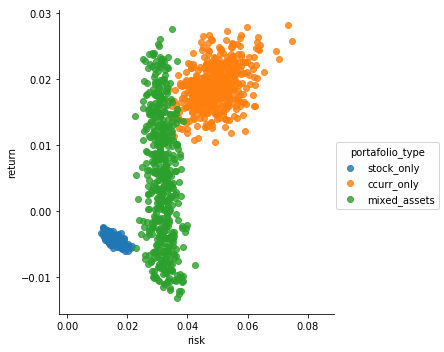

In [122]:
# Simulating Portfolios 
lag, window_time = 0, 30

# With mean
#simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations, lag, window_time,500)

# With Garch
simulations_stock_df, simulations_ccur_df, simulations_df = simulate_portafolios(random_simulations_using_garch, lag, window_time,500)

simulation_frames = [simulations_stock_df, simulations_ccur_df, simulations_df]
simulations_concatenated = pd.concat(simulation_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_concatenated, fit_reg=False)

*** Drawing Markowitz efficient frontier ***

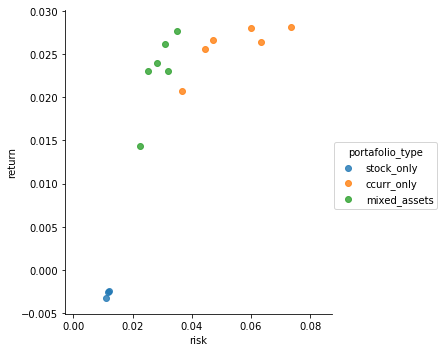

In [123]:
stock_frontier = drawing_frontier(simulations_stock_df)
ccur_frontier = drawing_frontier(simulations_ccur_df)
mixed_frontier = drawing_frontier(simulations_df)

summarized_frontiers = [stock_frontier, ccur_frontier, mixed_frontier]
summarized_frontiers = pd.concat(summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_frontiers, fit_reg=False)

In [124]:
stock_frontier

,assets,index,return,risk,weights,portafolio_type
78,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",78,-0.003285,0.011133,"[0.165158537319, 0.0417281734572, 0.0429002360...",stock_only
22,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",22,-0.002550,0.011809,"[0.151839410781, 0.0193110795638, 0.0433406984...",stock_only
163,"[stock_close_ABEV3, stock_close_ITUB4, stock_c...",163,-0.002446,0.011962,"[0.0580925763641, 0.0162740809825, 0.106184193...",stock_only


*** Ratio of Sharpe ***

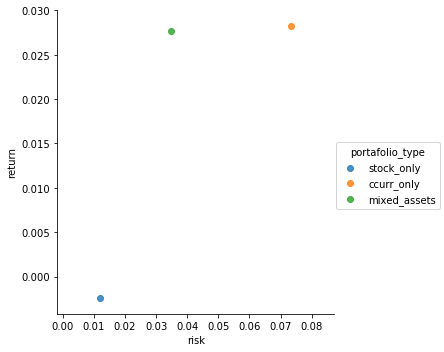

In [125]:
free_risk_asset = get_free_risk_asset_return(0.4, window_time)

# Calcuating ratio of sharpe of each asset belonging to the markwitz frontier

stock_frontier['ratio_of_sharpe'] = stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, free_risk_asset) , axis = 1)
ccur_frontier['ratio_of_sharpe'] = ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, free_risk_asset) , axis = 1)
mixed_frontier['ratio_of_sharpe'] = mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, free_risk_asset) , axis = 1)


# Finding the max ratio of sharpe of the markowitz frontier assets
df_sharpe_stock = stock_frontier.loc[stock_frontier['ratio_of_sharpe'] == max(stock_frontier['ratio_of_sharpe'])]
df_sharpe_ccur = ccur_frontier.loc[ccur_frontier['ratio_of_sharpe'] == max(ccur_frontier['ratio_of_sharpe'])]
df_sharpe_mixed_frontier =  mixed_frontier.loc[mixed_frontier['ratio_of_sharpe'] == max(mixed_frontier['ratio_of_sharpe'])]

# Ploting
summarized_sharpe = [df_sharpe_stock, df_sharpe_ccur, df_sharpe_mixed_frontier]
summarized_sharpe = pd.concat(summarized_sharpe)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=summarized_sharpe, fit_reg=False)

# Optimization with Genetic Algorithms

***OBS: *** Few data with a linear Opt. Function (substraction) tend to fall in local "maximus" (higher probabiity of exploit). Whereas a non-linear F.O. apparently does not.

### GA functions declaration

In [463]:
'''
@article{DEAP_JMLR2012, 
    author    = " F\'elix-Antoine Fortin and Fran\c{c}ois-Michel {De Rainville} and Marc-Andr\'e Gardner and Marc Parizeau and Christian Gagn\'e ",
    title     = { {DEAP}: Evolutionary Algorithms Made Easy },
    pages    = { 2171--2175 },
    volume    = { 13 },
    month     = { jul },
    year      = { 2012 },
    journal   = { Journal of Machine Learning Research }
'''

############### GA Implementation #############

def run_ga(percent_returns_pd, rate_returns_pd, use_garch = False):
    
    from deap import creator, base, tools, algorithms
    
    #Selecting which method should be used for calculating the returns by asset 
    if use_garch is False:
        returns = percent_returns_pd.mean()
        returns_cov = percent_returns_pd.cov()
    else:
        returns = rate_returns_pd.apply(lambda col: fit_garch(col)['results'])
        returns = returns.apply(lambda col: (np.exp(col) - 1)).iloc[-1]
        returns_cov = percent_returns_pd.cov()
    
    # Objective function
    def objective_function(individual):
        if sum(individual) == 0:
            total = 1e-2
        else:
            total = sum(individual)
        w = np.divide(individual, total)
        return_portafolio = returns.dot(w)
        std_portafolio = returns_cov.dot(w).dot(w) ** 0.5
        return (return_portafolio / std_portafolio,) 
    
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    num_assets = len(percent_returns_pd.columns)
    toolbox = base.Toolbox()
    toolbox.register("attr_flt", random.uniform, 0.001, 0.999)
    toolbox.register("individual", tools.initRepeat, creator.Individual,
                         toolbox.attr_flt, n=num_assets)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", objective_function)
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.3)
    toolbox.register("select", tools.selTournament, tournsize=3)

    population = toolbox.population(n=1000)
    hof = tools.HallOfFame(1)
    
    # Run GA
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    pop, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=40, 
                                       stats=stats, halloffame=hof, verbose=True)
    
    top10 = tools.selBest(population, k=10)
    return top10,pop, log, stats


############ Outputs processing ##############

def get_portafolio_stats(df_input, resource_optimal_distr):    
    average_close_portafolio = df_input.mean()
    cov_portafolio = df_input.cov()
    optimal_distr = resource_optimal_distr
    optimal_percentuals = np.divide(optimal_distr, sum(optimal_distr))
    return_in_percent = average_close_portafolio.dot(optimal_percentuals)
    risk_in_percent = cov_portafolio.dot(optimal_percentuals).dot(optimal_percentuals) ** 0.5
    return return_in_percent, risk_in_percent, resource_optimal_distr


## GA optimization - Workflow Example

***OBS:*** Experiments regarding the optimal number of assets are out of the scope of this work. Such number is defined by the premises adopted since the beginning. 
Considering the most signifcant companies/criptocurrencies according of its size. Companies with a minimum of 80% percent of summarized market capital.


In [464]:
def execute_by_interval(lag = 0, window_time = 30, is_garch = False):    
    
    tail = len(percent_returns_pd.index)
    
    # Stock only
    top10_stock, pop_stock, log_stock, stas_stock = run_ga(percent_stocks_returns[tail - (lag + window_time): tail - lag],
                                                           stock_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_stock:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_stocks_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_stock_output = pd.DataFrame.from_records(stats) 
    df_ga_stock_output.columns = ['return', 'risk', 'weights']
    df_ga_stock_output['portafolio_type'] = ['stock_only' for i in df_ga_stock_output.index]

    # Cripto Currencies only
    top10_ccurr, pop_ccurr, log_ccurr, stas_ccurr = run_ga(percent_cripto_returns[tail - (lag + window_time): tail - lag],
                                                           ccurr_return_rates[tail - (lag + window_time): tail - lag],
                                                           is_garch)
    stats = []
    for individual in pop_ccurr:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_cripto_returns[tail - (lag + window_time): tail - lag], pop))
    df_ga_ccur_output = pd.DataFrame.from_records(stats) 
    df_ga_ccur_output.columns = ['return', 'risk', 'weights']
    df_ga_ccur_output['portafolio_type'] = ['ccurr_only' for i in df_ga_ccur_output.index]
    
    top10, pop, log, stas = run_ga(percent_returns_pd[tail - (lag + window_time): tail - lag],
                                   return_rates_pd[tail - (lag + window_time): tail - lag],
                                   is_garch)
    stats = []
    for individual in pop:
        pop = np.divide(individual, sum(individual))
        stats.append(get_portafolio_stats(percent_returns_pd[tail - (lag + window_time): tail - lag], pop))
    df_ga_output = pd.DataFrame.from_records(stats) 
    df_ga_output.columns = ['return', 'risk', 'weights']
    df_ga_output['portafolio_type'] = ['mixed_assets' for i in df_ga_output.index]
    
    return df_ga_stock_output, df_ga_ccur_output, df_ga_output

In [431]:
# Exectuing optimization using means with returns

# Using mean for returns    
#df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, False)

# Using Garch for returns
df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval(0,30, True)

In [ ]:
simulation_ga_frames = [df_ga_stock_output, df_ga_ccur_output, df_ga_output]
simulations_ga_concatenated = pd.concat(simulation_ga_frames)

sns.lmplot(x="risk", y="return", hue="portafolio_type", data=simulations_ga_concatenated, fit_reg=False)

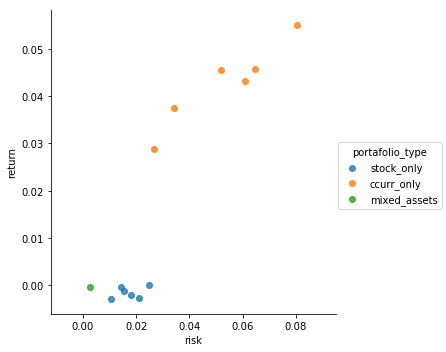

In [145]:
ga_stock_frontier = drawing_frontier(df_ga_stock_output)
ga_ccur_frontier = drawing_frontier(df_ga_ccur_output)
ga_mixed_frontier = drawing_frontier(df_ga_output)

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
pre_fixed_time_window = 5
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)

ga_summarized_frontiers = [ga_stock_frontier, ga_ccur_frontier, ga_mixed_frontier]
ga_summarized_frontiers = pd.concat(ga_summarized_frontiers)

sns.lmplot(x="risk", y="return",hue="portafolio_type", data=ga_summarized_frontiers, fit_reg=False)

### GA optimization vs Random Simulations

* Looking at the outcome plots of GA and Random simulation respectevaly, the main difference between these both is that GA allows a higher degree of the hyperspace exploration (Hyperspace is defined as the space where the possible silution are located), hence in GA the degree of exploting is lower, which enhaces the searching for global maximums.

* This might not be the case, but for portfolios composed by a signifacnlty higher number of assets, a random simulation dynamic is not suitable due this is considered a NP problem (not polynomial complexity problem in execution time).

## Optimizations(t) 

Once the optmization model is explained, the goal goes towards evaluate the protfolios behaviour in time.


** GA displacing time_window: ** It seeks to evaluate temporal behaviour considering a prefixed time_window displacing lags

In [525]:
tempos = dict()
num_iterations = 10

# Initialy we consider the lag per iteration with the same value of pre_fixed_time_window
lag_step_size, pre_fixed_time_window = 10, 45

# Required for ratio of sharpe
fixes_annual_return_rate = 0.4
ga_free_risk_asset = get_free_risk_asset_return(fixes_annual_return_rate, pre_fixed_time_window)

last_date = percent_returns_pd.index[-1]

for i in range(1,num_iterations+1):
    print((num_iterations-i)*lag_step_size, pre_fixed_time_window)
    df_ga_stock_output, df_ga_ccur_output, df_ga_output = execute_by_interval((num_iterations-i)*lag_step_size, pre_fixed_time_window, True)
    ga_stock_frontier,ga_ccur_frontier,ga_mixed_frontier = drawing_frontier(df_ga_stock_output), drawing_frontier(df_ga_ccur_output), drawing_frontier(df_ga_output)
   
    ga_stock_frontier['ratio_of_sharpe'] = ga_stock_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_stocks_returns, ga_free_risk_asset) , axis = 1)
    ga_ccur_frontier['ratio_of_sharpe'] = ga_ccur_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_cripto_returns, ga_free_risk_asset) , axis = 1)
    ga_mixed_frontier['ratio_of_sharpe'] = ga_mixed_frontier.apply(lambda x: get_ratio_of_sharpe(x['weights'], percent_returns_pd, ga_free_risk_asset) , axis = 1)
    
    partition_date = (datetime.strptime(last_date, '%Y-%m-%d') + relativedelta(days = -((num_iterations-i)*lag_step_size))).strftime('%Y-%m-%d')
    tempos[partition_date] = dict()
    tempos[partition_date]['stock_frontier'] = ga_stock_frontier
    tempos[partition_date]['ccur_frontier'] = ga_ccur_frontier
    tempos[partition_date]['mixed_frontier'] = ga_mixed_frontier

90 45


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max    
0  	1000  	0.234179	0.0145362	0.165963	0.27419
1  	645   	0.244021	0.0145194	0.159978	0.288116
2  	590   	0.252471	0.0153367	0.154761	0.289411
3  	561   	0.259457	0.0145638	0.171147	0.287622
4  	617   	0.265633	0.0163093	0.160162	0.295806
5  	576   	0.269664	0.0174742	0.166529	0.295806
6  	570   	0.272737	0.0198421	0.134809	0.296037
7  	604   	0.275685	0.0199298	0.147184	0.300184
8  	580   	0.277537	0.0229792	0.118156	0.300184
9  	602   	0.280043	0.0239344	0.122189	0.300087
10 	566   	0.281929	0.0259754	0.0733115	0.300087
11 	585   	0.283944	0.0258899	0.0913127	0.300087
12 	612   	0.284453	0.0270972	0.108973 	0.30015 
13 	582   	0.285882	0.0273199	0.0950116	0.300232
14 	626   	nan     	nan      	nan      	nan     
15 	568   	nan     	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


16 	619   	nan     	nan      	nan      	nan     
17 	637   	0.286481	0.0300781	0.129473 	0.300281
18 	616   	0.287439	0.0278005	0.145171 	0.300281
19 	589   	0.288579	0.0280711	0.106801 	0.300281
20 	602   	0.288281	0.0274159	0.14581  	0.30029 
21 	622   	0.287392	0.0290633	0.0735036	0.30029 
22 	579   	0.287544	0.0300156	0.0913127	0.30029 
23 	610   	0.287349	0.0279463	0.157687 	0.300292
24 	607   	0.285411	0.0311297	0.0937099	0.300292
25 	621   	0.286728	0.0304428	0.0367248	0.300292
26 	594   	0.287014	0.0302292	0.0913127	0.300292
27 	624   	0.286548	0.0286454	0.145359 	0.300292
28 	577   	0.287951	0.0288199	0.11817  	0.300292
29 	618   	0.287058	0.0288676	0.146538 	0.300292
30 	590   	0.286086	0.0301472	0.135311 	0.300292
31 	616   	0.287885	0.0285509	0.106801 	0.300292
32 	624   	0.288264	0.0284356	0.0937099	0.300292
33 	614   	nan     	nan      	nan      	nan     
34 	577   	0.287523	0.0282208	0.11817  	0.300292
35 	614   	0.287401	0.0302171	0.106801 	0.300292
36 	571   	0.287271	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encou

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer 

gen	nevals	avg      	std      	min     	max     
0  	1000  	0.0284769	0.0360739	-0.07489	0.162725
1  	573   	0.0593085	0.0367692	-0.0743159	0.252721
2  	558   	0.0870452	0.0356946	-0.0719205	0.252721
3  	614   	0.109068 	0.0405184	-0.0796191	0.268876
4  	602   	0.130419 	0.0459191	-0.0802928	0.273181
5  	613   	0.151031 	0.0521806	-0.0685958	0.273181
6  	588   	0.174166 	0.05336  	-0.0861587	0.273181
7  	575   	0.185359 	0.0646366	-0.127098 	0.297314
8  	593   	0.198324 	0.0693646	-0.142263 	0.297314
9  	584   	0.209064 	0.0762062	-0.162087 	0.302463
10 	594   	0.217739 	0.0851462	-0.154407 	0.304769
11 	585   	0.223024 	0.0915114	-0.118267 	0.302463
12 	594   	0.226133 	0.101601 	-0.10865  	0.30618 
13 	609   	0.23179  	0.1059   	-0.150896 	0.30618 
14 	578   	0.242247 	0.107567 	-0.16639  	0.30618 
15 	610   	0.247603 	0.105256 	-0.130187 	0.306206
16 	614   	0.246926 	0.112402 	-0.133481 	0.30618 
17 	605   	0.245815 	0.113911 	-0.162046 	0.30618 
18 	614   	0.254542 	0.10972  	-0.1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


20 	612   	nan      	nan      	nan       	nan     
21 	572   	0.254304 	0.109183 	-0.140452 	0.306206
22 	601   	0.248804 	0.115222 	-0.139012 	0.306206
23 	584   	0.255786 	0.110213 	-0.129657 	0.306206
24 	611   	0.246311 	0.118989 	-0.162046 	0.306206
25 	636   	0.254234 	0.113381 	-0.170573 	0.306206
26 	602   	nan      	nan      	nan       	nan     
27 	592   	nan      	nan      	nan       	nan     
28 	624   	nan      	nan      	nan       	nan     
29 	594   	0.249056 	0.117347 	-0.142189 	0.306206
30 	560   	0.253703 	0.113801 	-0.120132 	0.306206
31 	611   	0.248553 	0.115956 	-0.120132 	0.306206
32 	597   	0.251431 	0.113901 	-0.123433 	0.306206
33 	611   	0.251123 	0.113871 	-0.154407 	0.306206
34 	599   	0.256261 	0.10938  	-0.170573 	0.306206
35 	594   	0.25528  	0.109658 	-0.142189 	0.306206
36 	584   	0.247588 	0.11885  	-0.162087 	0.306206
37 	582   	0.251649 	0.115801 	-0.130358 	0.306206
38 	611   	0.255132 	0.110313 	-0.120132 	0.306206
39 	611   	0.2486   	0.117464 	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0246887	0.0183318	-0.078189	0.0379365
1  	584   	-0.00979834	0.0193606	-0.0844429	0.0666271
2  	618   	0.00508302 	0.0223079	-0.0860154	0.11224  
3  	609   	0.0214668  	0.0263343	-0.117721 	0.154092 
4  	596   	0.0357585  	0.031082 	-0.103244 	0.154092 
5  	561   	0.0525274  	0.0355357	-0.0988984	0.158798 
6  	584   	0.0696632  	0.0381662	-0.106434 	0.192812 
7  	594   	0.0841643  	0.0483048	-0.133413 	0.218611 
8  	598   	0.0983419  	0.0546773	-0.11187  	0.218611 
9  	621   	0.114557   	0.0606551	-0.112579 	0.22545  
10 	611   	0.126601   	0.0670238	-0.115598 	0.233953 
11 	554   	0.137769   	0.0742365	-0.124694 	0.248865 
12 	609   	0.148938   	0.0821315	-0.131165 	0.266186 
13 	574   	0.160681   	0.0878413	-0.140082 	0.26665  
14 	607   	0.170146   	0.0937011	-0.140679 	0.268075 
15 	605   	0.17869    	0.0995764	-0.119993 	0.281489 
16 	552   	0.191451   	0.102475 	-0.134117 	0.282152 
17 	589   	0.194134   	0.110534 

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min     	max     
0  	1000  	0.287496	0.0311954	0.192693	0.367847
1  	581   	0.310154	0.0315096	0.159796	0.4168  
2  	579   	0.329957	0.0317225	0.103137	0.426896
3  	612   	0.346185	0.0348175	0.0894115	0.443018
4  	600   	0.358329	0.0465387	0.0892924	0.469291
5  	597   	0.373337	0.0510231	0.0222042	0.469291
6  	642   	0.384379	0.0598347	-0.000162326	0.476705
7  	604   	0.401101	0.0619195	0.0123031   	0.476705
8  	616   	nan     	nan      	nan         	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	610   	nan     	nan      	nan         	nan     
10 	587   	0.431713	0.0771945	0.00329898  	0.476705
11 	579   	nan     	nan      	nan         	nan     
12 	607   	nan     	nan      	nan         	nan     
13 	594   	nan     	nan      	nan         	nan     
14 	609   	nan     	nan      	nan         	nan     
15 	609   	nan     	nan      	nan         	nan     
16 	597   	nan     	nan      	nan         	nan     
17 	619   	nan     	nan      	nan         	nan     
18 	631   	nan     	nan      	nan         	nan     
19 	618   	nan     	nan      	nan         	nan     
20 	655   	nan     	nan      	nan         	nan     
21 	592   	nan     	nan      	nan         	nan     
22 	628   	nan     	nan      	nan         	nan     
23 	607   	nan     	nan      	nan         	nan     
24 	552   	nan     	nan      	nan         	nan     
25 	592   	nan     	nan      	nan         	nan     
26 	600   	nan     	nan      	nan         	nan     
27 	634   	nan     	nan      	nan         	nan     
28 	620   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exc

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exceeded
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0344891	0.0252452	-0.107909	0.0573886
1  	621   	-0.0132059	0.0261917	-0.10343 	0.118586 
2  	622   	0.0076384 	0.0273363	-0.0806865	0.118759 
3  	595   	0.0265899 	0.0292302	-0.101098 	0.134616 
4  	631   	0.0439271 	0.0313698	-0.132463 	0.134616 
5  	595   	0.0589101 	0.0328602	-0.14047  	0.134616 
6  	586   	0.0700024 	0.0367109	-0.134184 	0.140398 
7  	589   	0.0811252 	0.0393095	-0.0910351	0.147536 
8  	608   	0.0861249 	0.0475598	-0.147912 	0.147536 
9  	587   	0.094941  	0.0488623	-0.136741 	0.147536 
10 	593   	0.100967  	0.0534782	-0.135135 	0.148176 
11 	617   	0.104045  	0.055429 	-0.122413 	0.154097 
12 	604   	0.106156  	0.0612057	-0.157045 	0.154097 
13 	575   	0.110559  	0.060973 	-0.175253 	0.157881 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


14 	599   	nan       	nan      	nan       	nan      
15 	616   	nan       	nan      	nan       	nan      
16 	621   	0.116065  	0.0689907	-0.139891 	0.157881 
17 	597   	nan       	nan      	nan       	nan      
18 	605   	0.121171  	0.071043 	-0.170787 	0.157881 
19 	596   	0.124542  	0.0692086	-0.157045 	0.157881 
20 	607   	0.116635  	0.079469 	-0.156529 	0.157881 
21 	603   	0.117383  	0.0788317	-0.161371 	0.157881 
22 	567   	nan       	nan      	nan       	nan      
23 	566   	0.124888  	0.0735723	-0.16625  	0.157881 
24 	589   	nan       	nan      	nan       	nan      
25 	577   	nan       	nan      	nan       	nan      
26 	595   	nan       	nan      	nan       	nan      
27 	572   	nan       	nan      	nan       	nan      
28 	579   	nan       	nan      	nan       	nan      
29 	581   	nan       	nan      	nan       	nan      
30 	593   	nan       	nan      	nan       	nan      
31 	606   	0.11924   	0.0810262	-0.174821 	0.157881 
32 	619   	0.121043  	0.0772154	-0.180413 	0.1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std     	min      	max      
0  	1000  	-0.0676327	0.020828	-0.126367	0.0160128
1  	608   	-0.0487346	0.0215318	-0.130501	0.0463754
2  	618   	-0.031461 	0.0225702	-0.120246	0.0704532
3  	601   	-0.0142571	0.0273101	-0.142941	0.165645 
4  	623   	0.00118112	0.0321588	-0.160347	0.165645 
5  	615   	0.0174944 	0.0386602	-0.126744	0.165645 
6  	609   	0.0357237 	0.0462786	-0.132997	0.302963 
7  	586   	0.0546229 	0.0559381	-0.160085	0.307366 
8  	580   	0.0752549 	0.0633532	-0.166899	0.307366 
9  	588   	0.10011   	0.0687129	-0.144582	0.337023 
10 	593   	0.123284  	0.0825551	-0.149656	0.346411 
11 	565   	0.15096   	0.0955969	-0.163677	0.359105 
12 	575   	0.175011  	0.114177 	-0.158486	0.378496 
13 	581   	0.21734   	0.113051 	-0.158776	0.376253 
14 	589   	0.233675  	0.134434 	-0.1725  	0.376283 
15 	608   	0.250242  	0.143828 	-0.194249	0.3969   
16 	591   	0.270989  	0.144027 	-0.167128	0.402488 
17 	580   	0.269918  	0.159929 	-0.150028	0.426406 
18 	605   	0.2

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


40 	601   	0.379886  	0.208044 	-0.208498	0.48079  
70 45


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg     	std      	min      	max     
0  	1000  	0.181488	0.0385196	0.0487304	0.286364
1  	643   	0.208335	0.0394655	-0.0225498	0.412158
2  	622   	0.235423	0.038947 	-0.014512 	0.412158
3  	580   	0.255504	0.0436464	-0.0490416	0.412158
4  	620   	0.272936	0.0517079	-0.0560246	0.412158
5  	596   	0.291041	0.0594973	-0.0196645	0.412158
6  	580   	0.311999	0.0611369	-0.0939596	0.412451


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


7  	586   	nan     	nan      	nan       	nan     
8  	607   	0.33958 	0.0785707	-0.0774171	0.412451
9  	576   	nan     	nan      	nan       	nan     
10 	594   	nan     	nan      	nan       	nan     
11 	598   	nan     	nan      	nan       	nan     
12 	631   	nan     	nan      	nan       	nan     
13 	621   	nan     	nan      	nan       	nan     
14 	599   	nan     	nan      	nan       	nan     
15 	636   	nan     	nan      	nan       	nan     
16 	606   	nan     	nan      	nan       	nan     
17 	593   	nan     	nan      	nan       	nan     
18 	588   	nan     	nan      	nan       	nan     
19 	610   	nan     	nan      	nan       	nan     
20 	583   	nan     	nan      	nan       	nan     
21 	585   	nan     	nan      	nan       	nan     
22 	584   	nan     	nan      	nan       	nan     
23 	587   	nan     	nan      	nan       	nan     
24 	610   	nan     	nan      	nan       	nan     
25 	623   	nan     	nan      	nan       	nan     
26 	618   	nan     	nan      	nan       	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:510: RuntimeWarning: invalid value encountered in double_scalars
  return 1.0 - e.T.dot(e) / y.dot(y)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/mean.py:195: RuntimeWarning: divide by zero encountered in log
  loglikelihood -= 0.5 * nobs * log(sigma2)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/volatility.py:871: RuntimeWarning: invalid value encountered in double_scalars
  scale = np.mean(resids ** 2) / (target ** (2.0 / power))
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 9. The message is:
Iteration limit exc

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min       	max      
0  	1000  	-0.0257509	0.0182651	-0.0834943	0.0312747
1  	589   	-0.0107123	0.0171777	-0.113056 	0.0529592
2  	608   	0.00183058	0.0179309	-0.130574 	0.110271 
3  	624   	0.0138188 	0.0187181	-0.135219 	0.0987993
4  	597   	0.0242065 	0.0213253	-0.105303 	0.121144 
5  	603   	0.0346532 	0.0242549	-0.118159 	0.121144 
6  	621   	0.0431284 	0.0282892	-0.146669 	0.121144 
7  	607   	0.0530804 	0.0288968	-0.0900714	0.121144 
8  	579   	0.0619139 	0.0330133	-0.0872338	0.12652  
9  	600   	0.0701951 	0.036574 	-0.109771 	0.12652  
10 	597   	0.0763874 	0.0411541	-0.151177 	0.12643  
11 	590   	0.0837679 	0.042434 	-0.138481 	0.12643  
12 	603   	0.0902642 	0.0443519	-0.110013 	0.126325 
13 	613   	0.0928628 	0.0481899	-0.120029 	0.126612 
14 	619   	nan       	nan      	nan       	nan      
15 	578   	nan       	nan      	nan       	nan      


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


16 	614   	nan       	nan      	nan       	nan      
17 	632   	nan       	nan      	nan       	nan      
18 	605   	0.0973553 	0.058918 	-0.140219 	0.127732 
19 	636   	0.0983039 	0.0587295	-0.140683 	0.128379 
20 	620   	0.0979478 	0.0603642	-0.168344 	0.128397 
21 	587   	0.0944199 	0.062428 	-0.119242 	0.128398 
22 	609   	nan       	nan      	nan       	nan      
23 	617   	0.0983354 	0.0594732	-0.167168 	0.128398 
24 	616   	0.0973679 	0.0616509	-0.114917 	0.128398 
25 	614   	0.10112   	0.055673 	-0.0926962	0.128398 
26 	600   	nan       	nan      	nan       	nan      
27 	610   	0.101075  	0.0571743	-0.162709 	0.128398 
28 	616   	nan       	nan      	nan       	nan      
29 	593   	nan       	nan      	nan       	nan      
30 	620   	0.102366  	0.0562761	-0.1692   	0.128398 
31 	608   	0.100436  	0.0578784	-0.137557 	0.128398 
32 	556   	0.102333  	0.0565717	-0.143145 	0.128398 
33 	595   	0.0979367 	0.0610647	-0.137557 	0.128398 
34 	607   	0.0969095 	0.0614004	-0.143145 	0.1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.152499	0.0191405	-0.207525	-0.082143
1  	619   	-0.135045	0.0199574	-0.216676	-0.0063984
2  	611   	-0.117885	0.0234034	-0.200537	0.0167863 
3  	590   	-0.101607	0.0302864	-0.196469	0.0818099 
4  	601   	-0.0839696	0.0351536	-0.203606	0.0818099 
5  	614   	-0.0657803	0.042787 	-0.265651	0.121068  
6  	610   	-0.0455291	0.0501929	-0.227332	0.121068  
7  	599   	-0.0235797	0.0567772	-0.253999	0.178127  
8  	623   	-0.0060598	0.0682702	-0.219936	0.172047  
9  	615   	0.0188093 	0.0742136	-0.239734	0.221348  
10 	608   	0.0421241 	0.0827924	-0.236691	0.282861  
11 	582   	0.063506  	0.0916131	-0.252672	0.282861  
12 	601   	0.0764706 	0.111587 	-0.241308	0.299695  
13 	565   	0.108316  	0.114454 	-0.241728	0.293222  
14 	622   	0.125875  	0.128054 	-0.214898	0.311903  
15 	601   	0.147218  	0.139392 	-0.251137	0.333578  
16 	588   	0.166254  	0.145459 	-0.246176	0.340734  
17 	580   	0.189937  	0.14819  	-0.2656  	0.340932  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0248659	0.0361195	-0.163983	0.0829135
1  	589   	0.00484178	0.0339014	-0.159309	0.114966 
2  	559   	0.0285419 	0.0348523	-0.145299	0.164136 
3  	601   	0.0506836 	0.0404819	-0.161296	0.168218 
4  	611   	0.0714705 	0.0469959	-0.217255	0.173625 
5  	583   	0.0922729 	0.0471146	-0.213483	0.188311 
6  	567   	0.106852  	0.0551668	-0.22122 	0.19842  
7  	590   	0.120514  	0.0582779	-0.231939	0.202511 
8  	578   	0.129639  	0.0636014	-0.211723	0.202511 
9  	602   	0.140626  	0.0667448	-0.213062	0.202784 
10 	590   	nan       	nan      	nan      	nan      
11 	590   	0.156248  	0.0757438	-0.213159	0.202784 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	542   	nan       	nan      	nan      	nan      
13 	608   	nan       	nan      	nan      	nan      
14 	628   	0.161702  	0.0811404	-0.213062	0.202806 
15 	613   	nan       	nan      	nan      	nan      
16 	606   	nan       	nan      	nan      	nan      
17 	597   	nan       	nan      	nan      	nan      
18 	617   	0.166933  	0.0811338	-0.213159	0.202806 
19 	618   	nan       	nan      	nan      	nan      
20 	587   	nan       	nan      	nan      	nan      
21 	574   	nan       	nan      	nan      	nan      
22 	569   	nan       	nan      	nan      	nan      
23 	571   	0.165035  	0.0844552	-0.200883	0.202806 
24 	610   	nan       	nan      	nan      	nan      
25 	553   	nan       	nan      	nan      	nan      
26 	592   	nan       	nan      	nan      	nan      
27 	610   	nan       	nan      	nan      	nan      
28 	581   	nan       	nan      	nan      	nan      
29 	587   	0.163128  	0.0838199	-0.217297	0.202806 
30 	561   	0.166042  	0.0832789	-0.220088	0.202806 
31 	613   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_

gen	nevals	avg       	std      	min       	max      
0  	1000  	-0.0385815	0.0165966	-0.0965681	0.0136457
1  	629   	-0.0245587	0.0157562	-0.0868891	0.0535064
2  	604   	-0.012099 	0.0166002	-0.111952 	0.0535064
3  	572   	-0.00108309	0.0174454	-0.0941755	0.0582085
4  	597   	0.00806212 	0.0191285	-0.095617 	0.0783498
5  	580   	0.01591    	0.0230368	-0.121437 	0.100264 
6  	617   	0.0239894  	0.02497  	-0.102965 	0.108919 
7  	626   	0.0306088  	0.0293834	-0.125597 	0.108919 
8  	564   	0.0383111  	0.0333606	-0.126326 	0.108919 
9  	611   	0.045931   	0.0379642	-0.140618 	0.109767 
10 	599   	0.0556369  	0.0414897	-0.154918 	0.110955 
11 	612   	0.0611148  	0.0475439	-0.168217 	0.110955 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	610   	nan        	nan      	nan       	nan      
13 	584   	nan        	nan      	nan       	nan      
14 	605   	nan        	nan      	nan       	nan      
15 	621   	nan        	nan      	nan       	nan      
16 	591   	nan        	nan      	nan       	nan      
17 	600   	nan        	nan      	nan       	nan      
18 	580   	0.0829548  	0.0580919	-0.160261 	0.111406 
19 	588   	0.0857577  	0.05578  	-0.186691 	0.111406 
20 	619   	0.0832583  	0.0573224	-0.186747 	0.111406 
21 	594   	0.0841841  	0.057487 	-0.202348 	0.111406 
22 	597   	0.0836088  	0.056874 	-0.174114 	0.111406 
23 	592   	0.0834913  	0.0576742	-0.140076 	0.111406 
24 	615   	0.0823859  	0.0600343	-0.160189 	0.111406 
25 	631   	0.0836244  	0.0583068	-0.202348 	0.111406 
26 	587   	0.083352   	0.0589449	-0.181185 	0.111406 
27 	612   	0.0800036  	0.060655 	-0.139202 	0.111406 
28 	620   	0.0782999  	0.0629159	-0.198221 	0.111406 
29 	607   	nan        	nan      	nan       	nan      
30 	604   	nan        	nan  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.169645	0.0148241	-0.215598	-0.125299
1  	578   	-0.157123	0.0137355	-0.215258	-0.107379
2  	591   	-0.146106	0.0146979	-0.235042	-0.0703144
3  	629   	-0.13597 	0.0165587	-0.208811	-0.051327 
4  	594   	-0.125659	0.0188705	-0.213695	-0.0465759
5  	642   	-0.116766	0.0245085	-0.303465	-0.0421084
6  	591   	-0.104527	0.0268071	-0.22668 	0.000873094
7  	560   	-0.0933777	0.0304884	-0.205371	0.000873094
8  	620   	-0.0851006	0.0374279	-0.238915	0.0224053  
9  	621   	-0.0736986	0.0409476	-0.300675	0.0774207  
10 	562   	-0.0610397	0.0440212	-0.22594 	0.0659526  
11 	585   	-0.0476086	0.0462419	-0.230847	0.0596919  
12 	588   	-0.0413794	0.053524 	-0.236993	0.0829073  
13 	595   	-0.0308227	0.0585246	-0.237065	0.111563   
14 	597   	-0.022348 	0.0658152	-0.238641	0.143309   
15 	613   	-0.0110721	0.0754034	-0.261376	0.143309   
16 	601   	-0.00186572	0.0857109	-0.242865	0.158736   
17 	610   	0.0163495  	0.0899292	-0.28194 	0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0976789	0.0397652	-0.263033	0.0253011
1  	594   	-0.0652786	0.0353427	-0.328458	0.0559033
2  	603   	-0.0405074	0.0302104	-0.233095	0.0725554
3  	588   	-0.0215791	0.0306577	-0.190126	0.101663 
4  	578   	-0.00366962	0.0366731	-0.31158 	0.101663 
5  	633   	0.010985   	0.0431185	-0.277904	0.111532 
6  	620   	0.0234219  	0.0482338	-0.267898	0.120819 
7  	599   	0.0352706  	0.0533928	-0.319443	0.114196 
8  	590   	0.0431728  	0.0621862	-0.314919	0.114196 
9  	619   	0.0513276  	0.0657501	-0.328149	0.120819 
10 	594   	0.060385   	0.0706277	-0.314919	0.120819 
11 	605   	0.0658953  	0.0766507	-0.314919	0.120819 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	595   	nan        	nan      	nan      	nan      
13 	589   	nan        	nan      	nan      	nan      
14 	658   	nan        	nan      	nan      	nan      
15 	616   	nan        	nan      	nan      	nan      
16 	598   	nan        	nan      	nan      	nan      
17 	608   	nan        	nan      	nan      	nan      
18 	563   	nan        	nan      	nan      	nan      
19 	591   	nan        	nan      	nan      	nan      
20 	595   	nan        	nan      	nan      	nan      
21 	589   	nan        	nan      	nan      	nan      
22 	589   	nan        	nan      	nan      	nan      
23 	595   	nan        	nan      	nan      	nan      
24 	617   	nan        	nan      	nan      	nan      
25 	600   	nan        	nan      	nan      	nan      
26 	628   	nan        	nan      	nan      	nan      
27 	615   	nan        	nan      	nan      	nan      
28 	610   	nan        	nan      	nan      	nan      
29 	611   	nan        	nan      	nan      	nan      
30 	608   	nan        	nan      	nan      	nan

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for c

gen	nevals	avg       	std      	min       	max      
0  	1000  	-0.0520678	0.0136747	-0.0937052	-0.012221
1  	587   	-0.0395746	0.0135047	-0.109466 	0.0142006
2  	612   	-0.029257 	0.013448 	-0.10893  	0.0253165
3  	595   	-0.0197879	0.014404 	-0.0920872	0.0274453
4  	607   	-0.0114579	0.0167061	-0.101503 	0.0425278
5  	574   	-0.00451932	0.0199075	-0.164658 	0.0465211
6  	633   	0.00100324 	0.0209134	-0.141056 	0.0504759
7  	602   	0.00824063 	0.021586 	-0.129962 	0.0687863
8  	562   	0.0134318  	0.0239567	-0.125749 	0.0687863
9  	639   	0.0181096  	0.0275543	-0.116991 	0.0687863
10 	588   	0.0250644  	0.0305274	-0.15225  	0.0687863
11 	584   	0.0330061  	0.0311448	-0.131726 	0.0689419
12 	576   	0.0365826  	0.0353323	-0.122612 	0.0689406
13 	590   	0.0391194  	0.0411846	-0.128277 	0.0692616
14 	619   	0.0426991  	0.0421703	-0.142448 	0.0692633
15 	605   	0.0446112  	0.0436503	-0.156943 	0.0693678
16 	602   	nan        	nan      	nan       	nan      
17 	610   	0.0446475  	0.0493323	-

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


18 	611   	0.0478238  	0.0452089	-0.129609 	0.0693678
19 	614   	nan        	nan      	nan       	nan      
20 	605   	nan        	nan      	nan       	nan      
21 	573   	nan        	nan      	nan       	nan      
22 	610   	nan        	nan      	nan       	nan      
23 	592   	nan        	nan      	nan       	nan      
24 	649   	0.0458393  	0.047509 	-0.152962 	0.0693699
25 	638   	0.0462324  	0.0477701	-0.15483  	0.0693699
26 	596   	0.0447671  	0.0480954	-0.130949 	0.0693699
27 	599   	0.0488318  	0.0455855	-0.155476 	0.0693699
28 	573   	0.0494106  	0.0441288	-0.15483  	0.0693699
29 	594   	0.0491558  	0.0444774	-0.153363 	0.0693699
30 	587   	0.0459063  	0.0487879	-0.15483  	0.0693699
31 	624   	0.046251   	0.0475985	-0.146627 	0.0693699
32 	573   	0.0469036  	0.046394 	-0.146627 	0.0693699
33 	612   	0.0450662  	0.048721 	-0.160603 	0.0693699
34 	591   	0.0484215  	0.0452947	-0.117403 	0.0693699
35 	605   	0.0478669  	0.0459715	-0.132964 	0.0693699
36 	590   	0.0483108  	0.045

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min     	max      
0  	1000  	-0.252131	0.0161456	-0.29623	-0.202211
1  	613   	-0.237711	0.0176034	-0.31465	-0.138437
2  	569   	-0.224099	0.0196955	-0.295  	-0.138437
3  	604   	-0.211065	0.0235941	-0.304273	-0.117897
4  	574   	-0.19704 	0.0283337	-0.31979 	-0.0891508
5  	592   	-0.180406	0.031338 	-0.293753	-0.0555101
6  	605   	-0.166727	0.0387023	-0.34059 	-0.0555101
7  	611   	-0.152266	0.0453587	-0.318323	-0.0401411
8  	565   	-0.134587	0.0475812	-0.315665	-0.0158971
9  	609   	-0.118247	0.0552021	-0.350747	-0.0136971
10 	649   	-0.105644	0.0634908	-0.322032	0.0135751 
11 	591   	-0.0840416	0.064836 	-0.32252 	0.0135751 
12 	581   	-0.0767934	0.0773478	-0.328194	0.0135751 
13 	576   	-0.0643488	0.081464 	-0.338866	0.0214643 
14 	583   	-0.0547433	0.0834405	-0.315328	0.0363372 
15 	572   	-0.0477602	0.0875926	-0.342216	0.0689695 
16 	633   	-0.0482741	0.0954768	-0.332987	0.0689695 
17 	608   	-0.0416303	0.0986738	-0.311269	0.0689695 
18 	607   	-0.

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg       	std      	min      	max      
0  	1000  	-0.0932421	0.0656575	-0.324557	0.0694561
1  	599   	-0.0390975	0.0546948	-0.33121 	0.124985 
2  	598   	0.00143005	0.0468776	-0.374405	0.151301 
3  	591   	0.032151  	0.047698 	-0.297538	0.175741 
4  	593   	0.0545776 	0.0577056	-0.463687	0.175741 
5  	597   	0.0749359 	0.0593911	-0.442184	0.180828 
6  	587   	0.0907092 	0.0703242	-0.342884	0.184982 
7  	579   	nan       	nan      	nan      	nan      
8  	602   	0.12267   	0.0751354	-0.47395 	0.184982 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	598   	0.129028  	0.0808769	-0.382028	0.184982 
10 	565   	0.131208  	0.0952183	-0.488267	0.185165 
11 	609   	0.140513  	0.0886038	-0.385964	0.18502  
12 	586   	nan       	nan      	nan      	nan      
13 	626   	0.142972  	0.0924362	-0.439923	0.18535  
14 	627   	nan       	nan      	nan      	nan      
15 	595   	nan       	nan      	nan      	nan      
16 	554   	nan       	nan      	nan      	nan      
17 	597   	nan       	nan      	nan      	nan      
18 	608   	nan       	nan      	nan      	nan      
19 	601   	nan       	nan      	nan      	nan      
20 	591   	nan       	nan      	nan      	nan      
21 	605   	nan       	nan      	nan      	nan      
22 	604   	nan       	nan      	nan      	nan      
23 	618   	0.142459  	0.103714 	-0.474526	0.18535  
24 	591   	0.140405  	0.101984 	-0.345335	0.18535  
25 	610   	0.146199  	0.0989269	-0.383269	0.18535  
26 	613   	nan       	nan      	nan      	nan      
27 	615   	nan       	nan      	nan      	nan      
28 	607   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_

gen	nevals	avg       	std      	min       	max      
0  	1000  	-0.0317966	0.0224621	-0.0966143	0.0333699
1  	587   	-0.0126718	0.0222535	-0.117158 	0.063786 
2  	616   	0.00318893	0.0238359	-0.142581 	0.0989024
3  	635   	0.0166621 	0.0262529	-0.145927 	0.0888765
4  	580   	0.0296931 	0.0291236	-0.157004 	0.122628 
5  	616   	0.0420885 	0.0324704	-0.130387 	0.120377 
6  	588   	0.0551104 	0.0337734	-0.127092 	0.130519 
7  	582   	0.0656493 	0.036375 	-0.14502  	0.130519 
8  	607   	0.0743204 	0.0411595	-0.147887 	0.13737  
9  	598   	0.0826493 	0.0435948	-0.147255 	0.13737  
10 	607   	0.089355  	0.0459722	-0.140161 	0.152851 
11 	588   	0.0937869 	0.0495341	-0.171901 	0.154357 
12 	608   	0.0961179 	0.053176 	-0.15027  	0.153202 
13 	580   	0.102482  	0.0503263	-0.157638 	0.157495 
14 	576   	0.103449  	0.057988 	-0.186053 	0.161472 
15 	575   	0.107614  	0.0583846	-0.15202  	0.161472 
16 	614   	0.108629  	0.0668735	-0.176909 	0.161472 
17 	580   	0.114848  	0.0702414	-0.173087 	0.1

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


18 	604   	nan       	nan      	nan       	nan      
19 	581   	nan       	nan      	nan       	nan      
20 	574   	nan       	nan      	nan       	nan      
21 	588   	nan       	nan      	nan       	nan      
22 	639   	nan       	nan      	nan       	nan      
23 	606   	nan       	nan      	nan       	nan      
24 	589   	nan       	nan      	nan       	nan      
25 	592   	nan       	nan      	nan       	nan      
26 	611   	nan       	nan      	nan       	nan      
27 	620   	nan       	nan      	nan       	nan      
28 	582   	nan       	nan      	nan       	nan      
29 	572   	nan       	nan      	nan       	nan      
30 	581   	nan       	nan      	nan       	nan      
31 	595   	nan       	nan      	nan       	nan      
32 	606   	nan       	nan      	nan       	nan      
33 	617   	nan       	nan      	nan       	nan      
34 	610   	nan       	nan      	nan       	nan      
35 	634   	nan       	nan      	nan       	nan      
36 	588   	nan       	nan      	nan       	nan

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg      	std      	min     	max      
0  	1000  	-0.153583	0.0234821	-0.22625	-0.077005
1  	573   	-0.132242	0.0244403	-0.236234	-0.00442466
2  	590   	-0.115349	0.0284353	-0.335095	-0.00194708
3  	615   	-0.0980945	0.0318637	-0.261575	0.0543154  
4  	588   	-0.0805415	0.0356429	-0.375525	0.0543154  
5  	598   	-0.0609885	0.0353656	-0.252355	0.0582871  
6  	590   	-0.045433 	0.0429947	-0.247168	0.0826132  
7  	581   	-0.0293007	0.0484441	-0.233868	0.0869221  
8  	607   	-0.0146071	0.054248 	-0.254452	0.11178    
9  	581   	0.000744486	0.0612781	-0.271345	0.118097   
10 	654   	0.0158846  	0.0677313	-0.269586	0.115248   
11 	614   	0.0282081  	0.0772319	-0.325521	0.146722   
12 	584   	0.047213   	0.0771321	-0.320873	0.146722   
13 	611   	0.0489462  	0.0919995	-0.327186	0.148061   
14 	640   	0.0621993  	0.0917047	-0.310984	0.149439   
15 	630   	0.0726675  	0.0950212	-0.250294	0.151126   
16 	607   	0.0818106  	0.0976515	-0.296507	0.154548   
17 	606   	0.0846572  	0.10247

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.149288	0.0718101	-0.387272	0.0628031
1  	564   	-0.0862473	0.0602388	-0.396644	0.111729 
2  	571   	-0.0387441	0.0488912	-0.266025	0.134229 
3  	581   	-0.0106645	0.0604629	-0.423108	0.135937 
4  	599   	0.0206317 	0.052231 	-0.378592	0.16369  
5  	591   	0.041139  	0.0659578	-0.397991	0.167835 
6  	591   	0.0562025 	0.081875 	-0.476992	0.167835 
7  	632   	0.0745013 	0.0837056	-0.477962	0.167864 
8  	619   	0.0831787 	0.100453 	-0.476629	0.167869 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


9  	592   	nan       	nan      	nan      	nan      
10 	615   	0.105922  	0.1036   	-0.493962	0.167872 
11 	625   	nan       	nan      	nan      	nan      
12 	605   	nan       	nan      	nan      	nan      
13 	600   	0.109644  	0.12897  	-0.490918	0.167872 
14 	582   	nan       	nan      	nan      	nan      
15 	594   	nan       	nan      	nan      	nan      
16 	608   	nan       	nan      	nan      	nan      
17 	557   	nan       	nan      	nan      	nan      
18 	589   	nan       	nan      	nan      	nan      
19 	632   	nan       	nan      	nan      	nan      
20 	594   	nan       	nan      	nan      	nan      
21 	625   	nan       	nan      	nan      	nan      
22 	612   	nan       	nan      	nan      	nan      
23 	594   	nan       	nan      	nan      	nan      
24 	602   	nan       	nan      	nan      	nan      
25 	606   	nan       	nan      	nan      	nan      
26 	626   	nan       	nan      	nan      	nan      
27 	565   	0.119639  	0.117084 	-0.476538	0.167872 
28 	612   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg       	std      	min     	max    
0  	1000  	-0.0670403	0.0281949	-0.14867	0.04126
1  	611   	-0.0423517	0.0288803	-0.163303	0.240252
2  	587   	-0.0186598	0.034803 	-0.124831	0.240252
3  	609   	0.00514719	0.0415163	-0.183   	0.240252
4  	600   	0.0232004 	0.0489575	-0.165289	0.240252
5  	638   	0.0462497 	0.0602886	-0.169914	0.28747 
6  	606   	0.0772359 	0.0722184	-0.195578	0.325744
7  	598   	0.10511   	0.0865147	-0.164545	0.396235
8  	577   	0.139277  	0.0990058	-0.186423	0.396497
9  	625   	0.172436  	0.112069 	-0.178137	0.396497
10 	606   	nan       	nan      	nan      	nan     
11 	584   	nan       	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	581   	nan       	nan      	nan      	nan     
13 	598   	0.288644  	0.152422 	-0.17901 	0.399992
14 	619   	0.303071  	0.158411 	-0.192944	0.400537
15 	594   	0.307939  	0.16539  	-0.18891 	0.400537
16 	578   	nan       	nan      	nan      	nan     
17 	619   	0.308063  	0.17445  	-0.196656	0.400537
18 	611   	0.315497  	0.169075 	-0.197444	0.400537
19 	589   	0.314919  	0.171849 	-0.183621	0.400537
20 	607   	nan       	nan      	nan      	nan     
21 	596   	0.322853  	0.167382 	-0.196427	0.400537
22 	606   	0.30417   	0.182862 	-0.193819	0.400537
23 	579   	0.31913   	0.169126 	-0.196224	0.400537
24 	593   	0.310661  	0.17614  	-0.173714	0.400537
25 	606   	0.322911  	0.166456 	-0.181765	0.400537
26 	587   	0.311094  	0.176551 	-0.179452	0.400537
27 	626   	0.314887  	0.173272 	-0.164784	0.400537
28 	605   	0.309714  	0.177545 	-0.179767	0.400537
29 	598   	0.321607  	0.168533 	-0.192887	0.400537
30 	610   	0.306473  	0.179557 	-0.205525	0.400537
31 	608   	0.309085  	0.17669  

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg       	std      	min      	max        
0  	1000  	-0.0560032	0.0162745	-0.123392	-0.00511088
1  	645   	-0.043007 	0.0156012	-0.12825 	0.0175836  
2  	591   	-0.0307411	0.0168743	-0.1358  	0.0404565  
3  	602   	-0.0197065	0.0172791	-0.123608	0.0361101  
4  	567   	-0.00964218	0.0202259	-0.117387	0.0476155  
5  	619   	0.000402506	0.0214971	-0.122445	0.0492338  
6  	594   	0.00834296 	0.0236397	-0.130703	0.0601598  
7  	608   	0.0163931  	0.0254599	-0.130278	0.065861   
8  	582   	0.0215837  	0.0280976	-0.121575	0.06793    
9  	578   	0.0266969  	0.0303714	-0.115988	0.0712166  
10 	599   	0.0306255  	0.0339913	-0.146   	0.0712166  
11 	615   	0.0348199  	0.0352957	-0.120309	0.0857607  
12 	608   	0.0397808  	0.0367642	-0.18452 	0.0857607  
13 	605   	0.0423164  	0.0389938	-0.187425	0.0866791  
14 	605   	0.0469202  	0.0391527	-0.127958	0.0926622  
15 	598   	0.0484923  	0.0427262	-0.147735	0.0948008  
16 	610   	0.0506872  	0.0478271	-0.179268	0.106418   
17 	585   	0.05

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max      
0  	1000  	-0.106918	0.0648937	-0.320645	0.0852841
1  	563   	-0.0482953	0.0618626	-0.430836	0.167259 
2  	646   	-0.00685395	0.0594745	-0.38907 	0.189811 
3  	592   	0.0308607  	0.0645184	-0.382362	0.199803 
4  	642   	0.0589442  	0.0776869	-0.457463	0.240801 
5  	587   	0.0874619  	0.0811546	-0.370192	0.26271  
6  	604   	0.118814   	0.0813722	-0.422696	0.286443 
7  	620   	0.137943   	0.0978134	-0.357956	0.286443 
8  	619   	0.154002   	0.116401 	-0.524826	0.286443 
9  	597   	0.17199    	0.12154  	-0.519764	0.286443 
10 	592   	nan        	nan      	nan      	nan      
11 	580   	nan        	nan      	nan      	nan      


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


12 	614   	nan        	nan      	nan      	nan      
13 	605   	nan        	nan      	nan      	nan      
14 	586   	nan        	nan      	nan      	nan      
15 	595   	nan        	nan      	nan      	nan      
16 	629   	nan        	nan      	nan      	nan      
17 	621   	nan        	nan      	nan      	nan      
18 	598   	nan        	nan      	nan      	nan      
19 	622   	nan        	nan      	nan      	nan      
20 	614   	nan        	nan      	nan      	nan      
21 	589   	nan        	nan      	nan      	nan      
22 	581   	nan        	nan      	nan      	nan      
23 	627   	nan        	nan      	nan      	nan      
24 	600   	nan        	nan      	nan      	nan      
25 	547   	nan        	nan      	nan      	nan      
26 	606   	nan        	nan      	nan      	nan      
27 	602   	nan        	nan      	nan      	nan      
28 	613   	nan        	nan      	nan      	nan      
29 	636   	nan        	nan      	nan      	nan      
30 	597   	nan        	nan      	nan      	nan

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_

gen	nevals	avg      	std     	min     	max       
0  	1000  	-0.717813	0.402274	-2.47406	-0.0329439
1  	620   	-0.361022	0.279007	-2.9736 	0.0922894 
2  	597   	-0.1842  	0.224598	-2.43534	0.0922894 
3  	580   	-0.105486	0.244449	-3.2608 	0.0970878 
4  	607   	-0.109309	0.402817	-5.66645	0.175206  
5  	587   	-0.0719814	0.372943	-4.18053	0.175206  
6  	609   	-0.138806 	0.803738	-12.104 	0.250921  
7  	572   	-0.0859703	0.567769	-7.68158	0.250921  
8  	592   	-0.0555707	0.548153	-8.33306	0.281069  
9  	580   	-0.0712902	0.772356	-9.40768	0.281069  
10 	582   	-0.0410389	1.01395 	-23.9186	0.283669  
11 	594   	0.0426354 	0.507632	-6.46901	0.288601  
12 	575   	0.0345633 	0.679366	-8.39225	0.288601  
13 	603   	0.0465016 	0.620282	-4.81607	0.288601  
14 	572   	0.0466301 	0.698615	-9.64284	0.290842  
15 	598   	0.0851833 	0.588927	-7.20295	0.290842  
16 	600   	nan       	nan     	nan     	nan       
17 	626   	0.117927  	0.598803	-7.43364	0.291514  


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


18 	578   	0.0651296 	1.83632 	-55.4138	0.291514  
19 	559   	nan       	nan     	nan     	nan       
20 	630   	nan       	nan     	nan     	nan       
21 	577   	nan       	nan     	nan     	nan       
22 	600   	nan       	nan     	nan     	nan       
23 	606   	nan       	nan     	nan     	nan       
24 	583   	nan       	nan     	nan     	nan       
25 	591   	nan       	nan     	nan     	nan       
26 	597   	nan       	nan     	nan     	nan       
27 	582   	nan       	nan     	nan     	nan       
28 	609   	nan       	nan     	nan     	nan       
29 	596   	0.0750213 	0.963144	-15.2165	0.293678  
30 	587   	0.112093  	0.676378	-7.52991	0.293678  
31 	609   	0.0520361 	0.777878	-7.59116	0.293678  
32 	610   	0.0578236 	0.983708	-16.0767	0.293678  
33 	600   	0.105447  	0.860228	-15.2165	0.293678  
34 	596   	0.121188  	0.792026	-15.2165	0.293678  
35 	567   	0.0847699 	0.619837	-4.49133	0.293678  
36 	629   	0.0466596 	2.9756  	-92.6455	0.293678  
37 	597   	0.115343  	0.609324	

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


gen	nevals	avg      	std      	min       	max      
0  	1000  	0.0107927	0.0243793	-0.0624141	0.0827616
1  	639   	0.0309049	0.0276026	-0.088166 	0.138111 
2  	595   	0.05039  	0.0302686	-0.158212 	0.166777 
3  	558   	0.0690189	0.0323234	-0.107436 	0.161006 
4  	616   	0.0852267	0.0367959	-0.120272 	0.195812 
5  	613   	0.101898 	0.0393384	-0.0797289	0.254861 
6  	628   	0.117685 	0.0423238	-0.110501 	0.221708 
7  	616   	0.128871 	0.0521512	-0.0994501	0.253613 
8  	559   	0.147785 	0.050139 	-0.131036 	0.261336 
9  	593   	0.162954 	0.0556841	-0.143219 	0.264633 
10 	547   	0.174006 	0.0614605	-0.0602015	0.2807   
11 	617   	0.186076 	0.0711682	-0.141985 	0.293632 
12 	575   	0.203005 	0.0727281	-0.100592 	0.293632 
13 	574   	0.212892 	0.0777865	-0.170722 	0.301852 
14 	589   	0.217765 	0.0888485	-0.191507 	0.313477 
15 	604   	0.22946  	0.0922085	-0.190014 	0.31558  
16 	596   	0.235904 	0.0995296	-0.201129 	0.323444 
17 	589   	0.2412   	0.104354 	-0.205457 	0.325807 
18 	592   	0

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max     
0  	1000  	-0.128906	0.0577899	-0.296118	0.057763
1  	586   	-0.0773261	0.0562336	-0.337198	0.23118 
2  	617   	-0.0326157	0.0603878	-0.318598	0.23118 
3  	555   	0.00654528	0.0693089	-0.29735 	0.23118 
4  	614   	0.0429319 	0.0775667	-0.337851	0.331512
5  	593   	0.080646  	0.0795414	-0.273647	0.331512
6  	553   	0.108524  	0.0885047	-0.356474	0.331512
7  	606   	0.132339  	0.0972934	-0.297754	0.331512
8  	635   	0.156802  	0.112721 	-0.356252	0.331512
9  	584   	0.180893  	0.130859 	-0.363884	0.331512
10 	575   	0.209707  	0.138426 	-0.366341	0.331512
11 	577   	0.230887  	0.149634 	-0.36166 	0.331512
12 	620   	0.246003  	0.158082 	-0.370517	0.331512
13 	569   	nan       	nan      	nan      	nan     
14 	579   	nan       	nan      	nan      	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


15 	610   	nan       	nan      	nan      	nan     
16 	625   	nan       	nan      	nan      	nan     
17 	592   	nan       	nan      	nan      	nan     
18 	568   	nan       	nan      	nan      	nan     
19 	559   	nan       	nan      	nan      	nan     
20 	626   	nan       	nan      	nan      	nan     
21 	545   	nan       	nan      	nan      	nan     
22 	594   	nan       	nan      	nan      	nan     
23 	585   	nan       	nan      	nan      	nan     
24 	606   	nan       	nan      	nan      	nan     
25 	595   	nan       	nan      	nan      	nan     
26 	599   	nan       	nan      	nan      	nan     
27 	608   	nan       	nan      	nan      	nan     
28 	566   	nan       	nan      	nan      	nan     
29 	560   	nan       	nan      	nan      	nan     
30 	627   	nan       	nan      	nan      	nan     
31 	572   	nan       	nan      	nan      	nan     
32 	616   	nan       	nan      	nan      	nan     
33 	635   	nan       	nan      	nan      	nan     
34 	575   	nan       	nan      

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std     	min      	max     
0  	1000  	0.308441	0.141893	0.0195628	0.957306
1  	592   	0.420302	0.165882	0.0132793	1.7075  
2  	604   	0.542031	0.220154	-0.0128087	3.10867 
3  	567   	0.661075	0.275391	0.00450256	3.10867 
4  	603   	0.773555	0.312648	0.003674  	3.10867 
5  	603   	0.936595	0.401891	-0.012241 	3.97562 
6  	593   	1.13271 	0.538596	-0.0183145	6.11758 
7  	596   	1.39271 	0.72623 	-0.0239372	6.11758 
8  	621   	1.69616 	0.947884	-0.0371247	6.52639 
9  	578   	2.13123 	1.17441 	-0.00880535	9.70189 
10 	603   	2.69522 	1.72665 	-0.0581464 	22.3567 
11 	577   	3.61002 	2.69392 	0.0113144  	25.9301 
12 	589   	4.76721 	4.07703 	-0.024833  	25.9301 
13 	601   	6.34767 	5.54245 	-0.0413933 	25.9301 
14 	605   	8.70197 	6.96635 	-0.0555809 	25.9301 
15 	580   	nan     	nan     	nan        	nan     
16 	609   	15.8501 	9.26485 	-0.0346262 	25.9301 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


17 	601   	nan     	nan     	nan        	nan     
18 	604   	nan     	nan     	nan        	nan     
19 	595   	nan     	nan     	nan        	nan     
20 	618   	nan     	nan     	nan        	nan     
21 	588   	20.6314 	10.3408 	-0.0579494 	25.9301 
22 	592   	20.6637 	10.3092 	-0.0596219 	25.9301 
23 	563   	nan     	nan     	nan        	nan     
24 	561   	20.6431 	10.3182 	-0.0333475 	25.9301 
25 	596   	nan     	nan     	nan        	nan     
26 	616   	nan     	nan     	nan        	nan     
27 	615   	nan     	nan     	nan        	nan     
28 	601   	nan     	nan     	nan        	nan     
29 	631   	nan     	nan     	nan        	nan     
30 	611   	nan     	nan     	nan        	nan     
31 	613   	nan     	nan     	nan        	nan     
32 	640   	nan     	nan     	nan        	nan     
33 	610   	nan     	nan     	nan        	nan     
34 	616   	nan     	nan     	nan        	nan     
35 	565   	nan     	nan     	nan        	nan     
36 	634   	nan     	nan     	nan        	nan     


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in true_divide
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/deap/creator.py:141: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  RuntimeWarning)


gen	nevals	avg      	std      	min     	max      
0  	1000  	-0.117188	0.0917599	-0.46144	0.0537095
1  	605   	-0.0438084	0.0669745	-0.413883	0.068549 
2  	596   	0.00363176	0.0417525	-0.347037	0.0916142
3  	620   	0.0293372 	0.0426434	-0.443367	0.102691 
4  	586   	0.0365329 	0.0832061	-1.00321 	0.125769 
5  	573   	0.044727  	0.0955354	-1.04215 	0.129319 
6  	583   	0.0529908 	0.0998974	-0.881768	0.137939 
7  	648   	0.0576601 	0.116097 	-1.0591  	0.139978 
8  	598   	0.0635054 	0.120192 	-0.932671	0.185009 
9  	584   	0.0706651 	0.137074 	-1.19016 	0.185009 
10 	612   	0.0762556 	0.138084 	-0.955855	0.190087 
11 	606   	0.0906136 	0.124069 	-1.15324 	0.203489 
12 	591   	0.100233  	0.134247 	-1.90017 	0.194555 
13 	579   	0.104479  	0.147084 	-1.84716 	0.198992 
14 	581   	0.109721  	0.146974 	-1.0733  	0.22923  
15 	615   	0.107201  	0.281081 	-5.30764 	0.234673 
16 	599   	0.119958  	0.170739 	-1.63424 	0.234673 
17 	585   	0.136562  	0.160629 	-2.26363 	0.248471 
18 	634   	0.127

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std     	min      	max      
0  	1000  	-0.177863	0.036987	-0.292841	-0.067525
1  	601   	-0.142895	0.040358	-0.335097	0.0654508
2  	585   	-0.11102 	0.046761	-0.312484	0.0794117
3  	576   	-0.0810582	0.0506113	-0.319558	0.101294 
4  	551   	-0.0504616	0.0547969	-0.419538	0.111787 
5  	602   	-0.0236867	0.0614471	-0.397132	0.147149 
6  	620   	0.00153872	0.0677006	-0.333978	0.147149 
7  	621   	0.0241928 	0.076762 	-0.321745	0.147149 
8  	604   	0.0373278 	0.090947 	-0.446405	0.147149 
9  	600   	0.0562662 	0.100587 	-0.447426	0.147149 


/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in double_scalars


10 	641   	nan       	nan      	nan      	nan      
11 	616   	nan       	nan      	nan      	nan      
12 	594   	nan       	nan      	nan      	nan      
13 	602   	nan       	nan      	nan      	nan      
14 	627   	nan       	nan      	nan      	nan      
15 	569   	nan       	nan      	nan      	nan      
16 	613   	nan       	nan      	nan      	nan      
17 	597   	nan       	nan      	nan      	nan      
18 	585   	nan       	nan      	nan      	nan      
19 	612   	nan       	nan      	nan      	nan      
20 	603   	nan       	nan      	nan      	nan      
21 	607   	nan       	nan      	nan      	nan      
22 	638   	nan       	nan      	nan      	nan      
23 	565   	nan       	nan      	nan      	nan      
24 	589   	nan       	nan      	nan      	nan      
25 	625   	nan       	nan      	nan      	nan      
26 	572   	nan       	nan      	nan      	nan      
27 	614   	nan       	nan      	nan      	nan      
28 	572   	nan       	nan      	nan      	nan      
29 	591   	n

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.opt

gen	nevals	avg     	std      	min     	max    
0  	1000  	0.240339	0.0532287	0.102778	0.40186
1  	595   	0.284786	0.0561803	0.0241855	0.499963
2  	617   	0.324557	0.0608016	0.0518224	0.50887 
3  	596   	0.359822	0.0662256	0.0472254	0.561638
4  	605   	0.396467	0.0705722	0.106568 	0.561638
5  	602   	0.420276	0.0824162	-0.00636185	0.561638
6  	577   	0.440569	0.0883951	0.0508881  	0.571323
7  	612   	0.461984	0.0876301	-0.0362853 	0.561638
8  	574   	0.476118	0.0953321	0.0525971  	0.575745
9  	592   	0.486239	0.101544 	0.0417391  	0.581086
10 	613   	0.493055	0.110002 	-0.0230465 	0.582075
11 	595   	0.501932	0.110418 	0.0514839  	0.600139
12 	603   	0.507794	0.114329 	0.0529851  	0.600139
13 	587   	0.520408	0.111143 	-0.0107647 	0.601176
14 	599   	0.519321	0.118856 	0.0512549  	0.602776
15 	605   	0.527273	0.120365 	0.0741568  	0.606007
16 	637   	0.521893	0.133097 	0.0407841  	0.606691
17 	578   	0.529075	0.130892 	-0.0627547 	0.611295
18 	621   	0.5277  	0.141352 	0.084708   	0.614

/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)
/Users/pecalvache/anaconda/envs/python3/lib/python3.6/site-packages/arch/univariate/base.py:524: ConvergenceWarning: 
The optimizer returned code 8. Th

gen	nevals	avg      	std      	min      	max       
0  	1000  	-0.117999	0.0151287	-0.172409	-0.0726003
1  	611   	-0.10495 	0.0141428	-0.168403	-0.0452407
2  	624   	-0.0940452	0.0147913	-0.178128	-0.0314987
3  	617   	-0.0848173	0.016167 	-0.175985	-0.0314987
4  	580   	-0.0767701	0.0191361	-0.236026	-0.0200098
5  	618   	-0.068005 	0.0204889	-0.1932  	-0.01041  
6  	596   	-0.0597896	0.0221742	-0.175818	-0.00902941
7  	593   	-0.051928 	0.0248873	-0.201554	0.00958886 
8  	602   	-0.0437438	0.0260188	-0.166218	0.0198181  
9  	610   	-0.0355986	0.02857  	-0.221666	0.0554923  
10 	595   	-0.0283317	0.0304466	-0.181659	0.0571998  
11 	573   	-0.0213637	0.0341317	-0.171798	0.0554923  
12 	596   	-0.015241 	0.0373606	-0.163202	0.0825261  
13 	611   	-0.0101369	0.0417737	-0.174928	0.0825261  
14 	627   	-0.00434186	0.0449378	-0.219077	0.0884919  
15 	569   	0.0021026  	0.0502905	-0.230642	0.0884919  
16 	622   	0.00810271 	0.0553184	-0.316635	0.0884919  
17 	586   	0.0176352  	0.0550866	-0

In [526]:
# Generating time series of best portfolios selected by ratio of sharpe

ccur_ts = dict()
stock_ts = dict()
mixed_ts = dict()
for k,v in tempos.items():
    ccur_ts[k] = v['ccur_frontier'].loc[v['ccur_frontier']['ratio_of_sharpe'] == max(v['ccur_frontier']['ratio_of_sharpe'])].values[0]
    ccur_columns = v['ccur_frontier'].columns
    stock_ts[k] = v['stock_frontier'].loc[v['stock_frontier']['ratio_of_sharpe'] == max(v['stock_frontier']['ratio_of_sharpe'])].values[0]
    stock_columns = v['stock_frontier'].columns
    mixed_ts[k] = v['mixed_frontier'].loc[v['mixed_frontier']['ratio_of_sharpe'] == max(v['mixed_frontier']['ratio_of_sharpe'])].values[0]
    mixed_columns = v['mixed_frontier'].columns
    
ccur_ts = pd.DataFrame.from_dict(ccur_ts, orient='index')
ccur_ts.columns = ccur_columns

stock_ts =  pd.DataFrame.from_dict(stock_ts, orient='index')
stock_ts.columns = stock_columns

mixed_ts = pd.DataFrame.from_dict(mixed_ts, orient='index')
mixed_ts.columns = mixed_columns

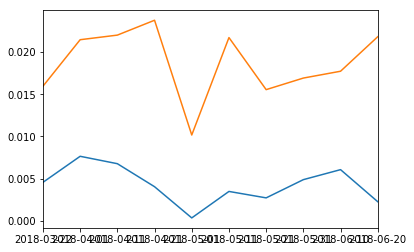

In [527]:
stock_ts['return'].plot()
stock_ts['risk'].plot()

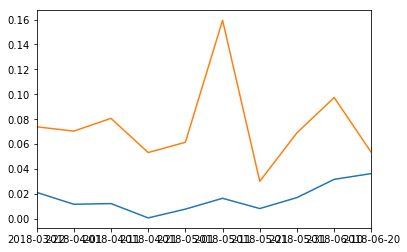

In [530]:
ccur_ts['return'].plot()
ccur_ts['risk'].plot()

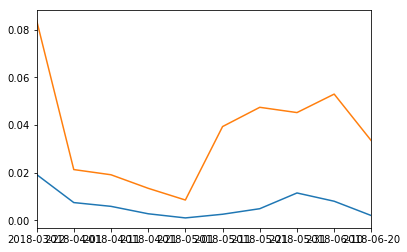

In [531]:
mixed_ts['return'].plot()
mixed_ts['risk'].plot()

In [532]:
# Calcular el VaR como medida interesante y mas fiable de los retornos
# Graficar el plot de las combinaciones de todos las combinaciones de las carteras

## Further outcome analysis

*** Temporal Aggregated Error and residual analysis ***

As the optimization takes place in specific days, the standard error of the estimate is defined as [David Longsteet]:

$$ Standard \ Error = \sqrt{\frac{\sum{{(\hat{Re} - Re)}^2}}{n-2}} $$




In [533]:
def get_errors(simulation_outcomes, returns_df, time_window = 30):
    substract_acum = 0
    predicted_returns, real_returns = list(), list()
    for date_index in simulation_outcomes.index:
        day = datetime.strptime(date_index, '%Y-%m-%d')
        # If the days checked are weekends, the friday before is considered instead
        test_date_index = date_index
        if day.weekday() == 5:
            test_date_index = (day + relativedelta(days = -1)).strftime('%Y-%m-%d')
        elif day.weekday() == 6:
            test_date_index = (day + relativedelta(days = -2)).strftime('%Y-%m-%d')

        # Holiday
        try:
            returns_df.loc[test_date_index]
        except:
            test_date_index = (datetime.strptime(test_date_index, '%Y-%m-%d') + relativedelta(days = -1)).strftime('%Y-%m-%d')
            
        real_return = returns_df.loc[test_date_index].dot(simulation_outcomes.loc[date_index]['weights'])
        predicted_return = simulation_outcomes.loc[date_index]['return']
        
        predicted_returns.append(predicted_return)
        real_returns.append(real_return)
        substract_acum += (np.subtract(predicted_return, real_return))**2
    
    std_error = np.sqrt(np.divide(substract_acum, time_window - 2))
    return std_error, predicted_returns, real_returns


def plot_error(predicted_returns, real_returns, index):
    p_series = pd.Series(predicted_returns)
    p_series.index = index
    r_series = pd.Series(real_returns)
    r_series.index = index
    
    p_series.plot()
    r_series.plot()

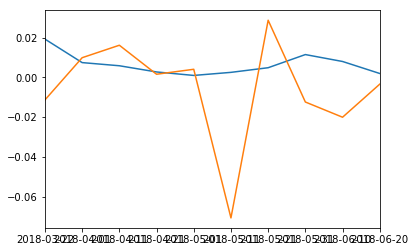

In [535]:
# Mixed
std_error, predicted_returns, real_returns = get_errors(mixed_ts, percent_returns_pd, pre_fixed_time_window)
plot_error(predicted_returns, real_returns, mixed_ts.index)

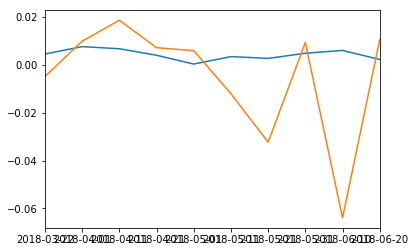

In [537]:
# stocks
std_error, predicted_returns, real_returns = get_errors(stock_ts, percent_stocks_returns)
plot_error(predicted_returns, real_returns, stock_ts.index)

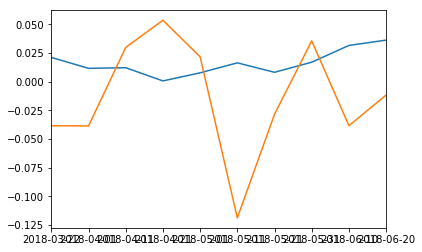

In [539]:
# Crypto
std_error, predicted_returns, real_returns = get_errors(ccur_ts, percent_cripto_returns)
plot_error(predicted_returns, real_returns, ccur_ts.index)

*** Summarized return in time: real vs predicted ***

*** Mixed assets portfolio distribution of the outcome ***

Once the optimal portoflio has been calculated in each time period where the model ran, it is also desired to explore further whether the composition of mixed protfolios presents any pattern or not. This aims towards giving a basic insight about the optimal distribution of a portfolio of such type by knowing the percent of the capital destinated to stocks and to the criptocurrencies.   

In [632]:
num_stock_asset = len(percent_stocks_returns.columns)
num_cripto_assets = len(percent_cripto_returns.columns)

mixed_ts['percent_in_stocks'] = [100*sum(portfolio[0:num_stock_asset]) for portfolio in mixed_ts['weights']]
mixed_ts['percent_in_cripto'] = [100*sum(portfolio[num_stock_asset:num_stock_asset+num_cripto_assets]) for portfolio in mixed_ts['weights']]

mixed_ts['lag_in_days'] = mixed_ts.index

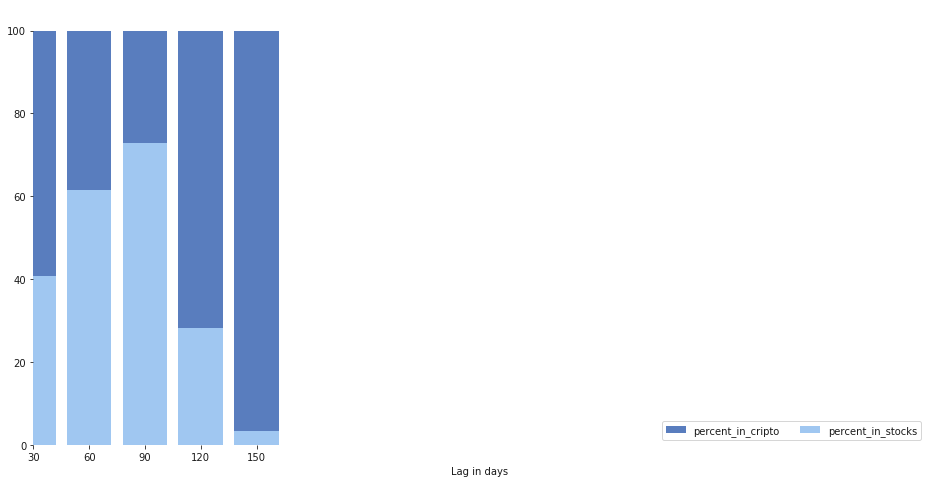

In [633]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(16, 8))

mixed_ts['temp_dim'] = [100 for portfolio in mixed_ts['weights']]
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="lag_in_days", y="temp_dim", data=mixed_ts,
            label="percent_in_cripto", color="b")

# Plot the total crashes
sns.set_color_codes("pastel")
sns.barplot(x="lag_in_days", y="percent_in_stocks", data=mixed_ts,
            label="percent_in_stocks", color="b")


# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 16), ylabel="",
       xlabel="Lag in days")
sns.despine(left=True, bottom=True)

In [634]:
# Cleaning df
mixed_ts.drop(['temp_dim', 'lag_in_days'], axis = 1)

,return,risk,weights,portafolio_type,ratio_of_sharpe,percent_in_stocks,percent_in_cripto
150,0.012855,0.045616,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.032...",mixed_assets,-0.249399,3.230175,96.769825
120,0.049416,0.095202,"[0.0, 0.0, 0.109338355367, 0.0, 0.0, 0.1488134...",mixed_assets,-0.379809,28.252366,71.747634
90,0.004382,0.035520,"[0.135076513561, 0.135076513561, 0.0, 0.0, 0.0...",mixed_assets,-0.884798,72.984697,27.015303
60,0.004722,0.028266,"[0.335763435359, 0.0, 0.0, 0.280078517722, 0.0...",mixed_assets,-0.738469,61.584195,38.415805
30,0.012323,0.046801,"[0.204504213743, 0.0, 0.0, 0.0, 0.202093331283...",mixed_assets,-0.409423,40.659755,59.340245


# TO DO:

* Clean data, at least for criptocurrencies with few tracking history registers. [X]
* Fix when a big amount of past data is considered when performing optmizations [OK]
* Select most valuable assets of Bovespa [OK - But considering the state in Marxh Only]
* Demonstrate variation between cotations in real and dolar - Not relevant because a differianted series is taken.
* Calculate the mixed portfolios distribution in 3 stages:
    * Ratio of sharpe
    * Max. return
    * Min. Risk
    
* Real error analysis (Mean - retorno real) for normal AVG - and AVG
* GARCH models, calculate the return of a single asset, this will minimize the error.
* Calculate the real return after calculating all optimized portfolios within the defined time interval.